---

## 1. LIBRERÍAS


In [67]:
import os
import json
import time
import pandas as pd
import ast
import unicodedata
from unidecode import unidecode
# from google.oauth2 import service_account
# from google.cloud import aiplatform
# from google.api_core import exceptions
# from vertexai.generative_models import GenerativeModel, GenerationConfig
# Importamos solo lo que está disponible en tu versión de SDK

In [68]:
import re
import io
import csv
import numpy as np
from tqdm import tqdm
import zipfile

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Deep Learning & Generative AI
# import torch
# import tensorflow as tf
# import transformers
# import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
# import nltk
# import spacy

# Data Handling
# import openpyxl
# from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build

# Other utilities
import requests
from tenacity import retry
from google.cloud import bigquery

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

---

## 2. CARGA DE DATOS

Cargamos las conversaciones de Conecta+ desde archivos históricos y el ZIP más reciente del sistema.

#### CONECTA+

In [69]:
RUTA_HISTORICO = "df_resultados.csv"
conecta_2_evaluados = pd.read_csv(RUTA_HISTORICO, sep=',')

conecta_2_evaluados.conversation_id = conecta_2_evaluados.conversation_id.astype(int)

In [70]:
def parse_csv_with_multiline_fields(file_path):
    """
    Parse CSV file that has newlines within quoted fields.
    Handles CSV-escaped quotes (doubled quotes: "").
    
    Uses a character-by-character state machine approach:
    - Tracks quote state to know when we're inside/outside quoted fields
    - Handles escaped quotes ("" becomes ")
    - Accumulates lines until complete record is found
    """
    records = []
    current_record = []
    current_field = []
    in_quotes = False
    header = None
    prev_char = ''

    with open(file_path, 'r', encoding='utf-8') as f:
        char_iter = iter(lambda: f.read(1), '')

        for char in char_iter:
            if char == '"':
                # Check if this is an escaped quote (doubled: "")
                if prev_char == '"' and in_quotes:
                    # This is an escaped quote - add one quote to field
                    current_field.append('"')
                    prev_char = ''  # Reset to avoid triple-quote issues
                    continue
                else:
                    # Toggle quote state
                    in_quotes = not in_quotes
                    prev_char = char
                    continue

            if not in_quotes:
                if char == ',':
                    # End of field
                    current_record.append(''.join(current_field))
                    current_field = []
                elif char == '\n':
                    # End of record
                    if current_field or current_record:
                        current_record.append(''.join(current_field))
                        current_field = []

                        if header is None:
                            header = current_record
                        else:
                            if len(current_record) == len(header):
                                records.append(current_record)
                        current_record = []
                else:
                    current_field.append(char)
            else:
                # Inside quotes - add everything including newlines
                current_field.append(char)

            prev_char = char

        # Handle last field/record
        if current_field or current_record:
            current_record.append(''.join(current_field))
            if len(current_record) == len(header):
                records.append(current_record)

    df = pd.DataFrame(records, columns=header)
    return df

In [71]:
# --- Constantes ---
ARCHIVOS_OBJETIVO = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
    'tbl_preguntas_conversacion_conecta2.csv'
]

# --- FUNCIÓN DE CARGA MEJORADA PARA MANEJAR RESPUESTAS CON NEWLINES ---
def parse_preguntas_csv_from_zip(zip_ref, filename='tbl_preguntas_conversacion_conecta2.csv'):
    """
    Hybrid approach: Use csv.reader (handles most quotes correctly) then merge continuation rows.
    
    Some rows have improperly quoted multiline fields that csv.reader splits incorrectly.
    We detect these by checking if a row starts with valid numeric ID+FK.
    """
    with zip_ref.open(filename, 'r') as f:
        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
        reader = csv.reader(text_stream)
        raw_rows = list(reader)
    
    header = raw_rows[0]
    expected_cols = len(header)
    
    # Merge fragmented rows
    reconstructed_rows = []
    current_row = None
    
    for i, row in enumerate(raw_rows[1:], 1):
        # Check if this is the start of a new valid record
        is_new_record = False
        
        if len(row) >= 2:
            try:
                int(row[0])  # Valid ID
                int(row[1])  # Valid FK
                is_new_record = True
            except ValueError:
                is_new_record = False
        
        if is_new_record:
            # Save previous row if exists
            if current_row is not None:
                reconstructed_rows.append(current_row)
            current_row = row[:]
        else:
            # Continuation row - merge into last field of current row
            if current_row is not None and len(row) > 0:
                if len(current_row) > 0:
                    # Join the continuation data with newline
                    current_row[-1] += '\n' + ','.join(row)
    
    # Don't forget the last row
    if current_row is not None:
        reconstructed_rows.append(current_row)
    
    # Post-process: ensure all rows have exactly expected_cols columns
    final_rows = []
    for row in reconstructed_rows:
        # Handle rows that were split incorrectly by csv.reader
        # Expected structure: [ID, FK, pregunta, respuesta, calificacion, comentario]
        
        if len(row) == 4:
            # [ID, FK, pregunta, respuesta_with_maybe_calificacion_comentario]
            # Check if last column contains ",Mal/Bien/NULL at the end
            last_col = row[3]
            if '",Mal' in last_col or '",Bien' in last_col or '",NULL' in last_col:
                # Split out calificacion and comentario
                if '",Mal,' in last_col:
                    parts = last_col.rsplit('",Mal,', 1)
                    row = row[:3] + [parts[0] + '"', 'Mal', parts[1]]
                elif '",Mal' in last_col and last_col.endswith('",Mal'):
                    parts = last_col.rsplit('",Mal', 1)
                    row = row[:3] + [parts[0] + '"', 'Mal', '']
                elif '",Bien,' in last_col:
                    parts = last_col.rsplit('",Bien,', 1)
                    row = row[:3] + [parts[0] + '"', 'Bien', parts[1]]
                elif '",Bien' in last_col and last_col.endswith('",Bien'):
                    parts = last_col.rsplit('",Bien', 1)
                    row = row[:3] + [parts[0] + '"', 'Bien', '']
                elif '",NULL,' in last_col:
                    parts = last_col.rsplit('",NULL,', 1)
                    row = row[:3] + [parts[0] + '"', '', parts[1]]
                elif '",NULL' in last_col and last_col.endswith('",NULL'):
                    parts = last_col.rsplit('",NULL', 1)
                    row = row[:3] + [parts[0] + '"', '', '']
                else:
                    row = row + ['', '']
            else:
                row = row + ['', '']
        
        elif len(row) == 5:
            # [ID, FK, pregunta, partial_respuesta, more_respuesta_with_maybe_calificacion_comentario]
            # Check if last column contains ",Mal/Bien/NULL
            last_col = row[4]
            if '",Mal' in last_col or '",Bien' in last_col or '",NULL' in last_col:
                # Split out calificacion and comentario
                if '",Mal,' in last_col:
                    parts = last_col.rsplit('",Mal,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Mal', parts[1]]
                elif '",Mal' in last_col and last_col.endswith('",Mal'):
                    parts = last_col.rsplit('",Mal', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Mal', '']
                elif '",Bien,' in last_col:
                    parts = last_col.rsplit('",Bien,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Bien', parts[1]]
                elif '",Bien' in last_col and last_col.endswith('",Bien'):
                    parts = last_col.rsplit('",Bien', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, 'Bien', '']
                elif '",NULL,' in last_col:
                    parts = last_col.rsplit('",NULL,', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, '', parts[1]]
                elif '",NULL' in last_col and last_col.endswith('",NULL'):
                    parts = last_col.rsplit('",NULL', 1)
                    merged_respuesta = row[3] + parts[0] + '"'
                    row = row[:3] + [merged_respuesta, '', '']
                else:
                    # Merge columns 3 and 4 into respuesta
                    merged_respuesta = row[3] + row[4]
                    row = row[:3] + [merged_respuesta, '', '']
            else:
                # Merge columns 3 and 4 into respuesta
                merged_respuesta = row[3] + row[4]
                row = row[:3] + [merged_respuesta, '', '']
        
        elif len(row) < expected_cols:
            # Pad with empty strings for any other case
            row = row + [''] * (expected_cols - len(row))
        
        elif len(row) > expected_cols:
            # Too many columns - merge extras into respuesta (index 3)
            num_extra = len(row) - expected_cols
            respuesta_parts = row[3:3+num_extra+1]
            merged_respuesta = ','.join(respuesta_parts)
            row = row[:3] + [merged_respuesta] + row[3+num_extra+1:]
        
        final_rows.append(row[:expected_cols])
    
    # Create DataFrame
    df = pd.DataFrame(final_rows, columns=header)
    df = df.replace('NULL', pd.NA)
    df = df.replace('', pd.NA)
    df['id_tbl_preguntas_conversacion_conecta2'] = pd.to_numeric(df['id_tbl_preguntas_conversacion_conecta2'], errors='coerce')
    df['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(df['fk_tbl_conversaciones_conecta2'], errors='coerce')
    
    return df

def cargar_dataframes_zip(zip_path, archivos_objetivo):
    """
    Carga DataFrames desde ZIP con manejo especial para tbl_preguntas_conversacion_conecta2.csv
    que contiene newlines sin escapar en el campo respuesta.
    """
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for archivo_base in archivos_objetivo:
            archivo_encontrado = next((f for f in zip_ref.namelist() 
                                      if f.startswith(archivo_base.replace('.csv', ''))), None)
            
            if not archivo_encontrado:
                print(f"Advertencia: No se encontró '{archivo_base}'. DataFrame vacío.")
                dataframes[archivo_base] = pd.DataFrame()
                continue
            
            print(f"Procesando: '{archivo_encontrado}'...")
            
            try:
                # Special handling for preguntas file
                if 'preguntas_conversacion' in archivo_base:
                    df = parse_preguntas_csv_from_zip(zip_ref, archivo_encontrado)
                    print(f"  ✓ Cargadas {len(df):,} filas con {df['fk_tbl_conversaciones_conecta2'].nunique():,} conversaciones únicas")
                else:
                    # Standard CSV reading for other files
                    with zip_ref.open(archivo_encontrado, 'r') as f:
                        text_stream = io.TextIOWrapper(f, encoding='utf-8', errors='replace')
                        df = pd.read_csv(text_stream)
                        df = df.replace('NULL', pd.NA)
                        print(f"  ✓ Cargadas {len(df):,} filas")
                
                dataframes[archivo_base] = df
                
            except Exception as e:
                print(f"Error al procesar '{archivo_encontrado}': {e}")
                dataframes[archivo_base] = pd.DataFrame()
    
    return dataframes

In [ ]:
# --- FUNCIONES PARA LEER ARCHIVOS JSON ---

def cargar_dataframes_json_zip(zip_path, archivos_objetivo):
    """
    Carga DataFrames desde ZIP que contiene archivos JSON.
    
    Los archivos JSON tienen estructura:
    {
        "SELECT * FROM tabla_name": [
            {"campo1": valor1, "campo2": valor2, ...},
            ...
        ]
    }
    
    Mapea los nombres CSV a patrones JSON y extrae los datos.
    """
    dataframes = {}
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Listar todos los archivos en el ZIP
        archivos_disponibles = zip_ref.namelist()
        print(f"📦 Archivos encontrados en ZIP: {len(archivos_disponibles)}")
        
        for archivo_base in archivos_objetivo:
            # Mapear nombre CSV a patrón JSON
            # Ej: 'tbl_conversaciones_conecta2.csv' -> buscar archivo que contenga 'tbl_conversaciones_conecta2' y termine en '.json'
            tabla_nombre = archivo_base.replace('.csv', '')
            
            # Buscar archivo JSON que coincida
            archivo_encontrado = None
            for archivo in archivos_disponibles:
                if tabla_nombre in archivo and archivo.endswith('.json'):
                    archivo_encontrado = archivo
                    break
            
            if not archivo_encontrado:
                print(f"⚠️  Advertencia: No se encontró '{archivo_base}' (buscando patrón '{tabla_nombre}.json'). DataFrame vacío.")
                dataframes[archivo_base] = pd.DataFrame()
                continue
            
            print(f"📄 Procesando: '{archivo_encontrado}'...")
            
            try:
                # Leer archivo JSON del ZIP
                with zip_ref.open(archivo_encontrado, 'r') as f:
                    data = json.load(f)
                    
                    # La estructura es: {"SELECT * FROM tabla": [{registro1}, {registro2}, ...]}
                    # Extraer la lista de registros (primer valor del diccionario)
                    if isinstance(data, dict):
                        # Obtener el primer (y único) valor del diccionario
                        records = list(data.values())[0]
                        
                        # Convertir a DataFrame
                        df = pd.DataFrame(records)
                        
                        # Reemplazar null por pd.NA
                        df = df.replace({None: pd.NA, 'null': pd.NA, 'NULL': pd.NA})
                        
                        print(f"  ✓ Cargadas {len(df):,} filas")
                        if 'fk_tbl_conversaciones_conecta2' in df.columns:
                            print(f"    {df['fk_tbl_conversaciones_conecta2'].nunique():,} conversaciones únicas")
                        
                        dataframes[archivo_base] = df
                    else:
                        print(f"  ⚠️  Formato JSON inesperado (esperaba dict, recibí {type(data)})")
                        dataframes[archivo_base] = pd.DataFrame()
                
            except Exception as e:
                print(f"  ❌ Error al procesar '{archivo_encontrado}': {e}")
                dataframes[archivo_base] = pd.DataFrame()
    
    return dataframes


def detectar_tipo_zip(zip_path):
    """
    Detecta si el ZIP contiene archivos CSV o JSON.
    
    Returns:
        str: 'csv' o 'json'
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        archivos = zip_ref.namelist()
        
        # Contar archivos CSV y JSON
        csv_count = sum(1 for f in archivos if f.endswith('.csv'))
        json_count = sum(1 for f in archivos if f.endswith('.json'))
        
        if json_count > csv_count:
            return 'json'
        else:
            return 'csv'


def cargar_dataframes_auto(zip_path, archivos_objetivo):
    """
    Función wrapper que detecta automáticamente el tipo de archivo (CSV o JSON)
    y llama a la función de carga apropiada.
    """
    tipo = detectar_tipo_zip(zip_path)
    print(f"🔍 Tipo de archivo detectado: {tipo.upper()}")
    
    if tipo == 'json':
        return cargar_dataframes_json_zip(zip_path, archivos_objetivo)
    else:
        return cargar_dataframes_zip(zip_path, archivos_objetivo)

### 2.1b Soporte para archivos JSON

A partir de noviembre 2025, los archivos ZIP pueden venir en formato JSON en lugar de CSV.

**Estructura de archivos JSON:**
```json
{
  "SELECT * FROM tabla_name": [
    {"campo1": valor1, "campo2": valor2, ...},
    ...
  ]
}
```

**Funcionalidades añadidas:**
- `cargar_dataframes_json_zip()`: Lee archivos JSON del ZIP y los convierte a DataFrames
- `detectar_tipo_zip()`: Detecta automáticamente si el ZIP contiene CSV o JSON
- `cargar_dataframes_auto()`: Wrapper que selecciona la función de carga apropiada

Esto permite que el notebook funcione con ambos formatos sin cambios manuales.

In [ ]:
# --- Cargar DataFrames desde ZIP ---
ZIP_PATH = '20251120.zip'

# Usar función automática que detecta CSV o JSON
dataframes = cargar_dataframes_auto(ZIP_PATH, ARCHIVOS_OBJETIVO)

# Asignar a variables individuales
conversaciones_conecta = dataframes['tbl_conversaciones_conecta2.csv']
encuesta_chat_ia_conecta = dataframes['tbl_encuesta_chat_ia_conecta2.csv']
preguntas_conversacion_conecta = dataframes['tbl_preguntas_conversacion_conecta2.csv']

print(f"\n=== DataFrames cargados ===")
print(f"conversaciones_conecta: {len(conversaciones_conecta):,} filas")
print(f"encuesta_chat_ia_conecta: {len(encuesta_chat_ia_conecta):,} filas")
print(f"preguntas_conversacion_conecta: {len(preguntas_conversacion_conecta):,} filas")

## 2.2 Post-procesamiento: Limpieza de Datos

Después de cargar los datos del CSV, aplicamos dos funciones de limpieza para corregir inconsistencias en las columnas `calificacion` y `comentario`:

### Problemas detectados:
1. **Columna `calificacion`**: Contiene 718 valores únicos cuando solo debería tener `'Mal'`, `'Bien'`, o `NA`
   - Los valores inválidos son texto que debería estar en la columna `respuesta`
   
2. **Columna `comentario`**: Algunos registros terminan con el patrón `",NULL,NULL"` que indica que datos de `respuesta` y `calificacion` se filtraron incorrectamente

### Solución:
- `limpiar_calificacion()`: Verifica valores válidos y mueve texto inválido a `respuesta`
- `limpiar_comentario()`: Detecta el patrón y redistribuye los valores a las columnas correctas

In [73]:
# --- Post-procesamiento: Limpieza de columnas calificacion y comentario ---

def limpiar_calificacion(df):
    """
    Verifica que la columna 'calificacion' solo contenga valores válidos: 'Mal', 'Bien', o NA.
    Si encuentra un valor inválido, lo agrega al final de 'respuesta' y marca calificacion como NA.
    """
    valores_validos = {'Mal', 'Bien'}
    filas_corregidas = 0
    
    for idx, row in df.iterrows():
        calificacion_actual = row['calificacion']
        
        # Si calificacion no es NA y no está en valores válidos
        if pd.notna(calificacion_actual) and calificacion_actual not in valores_validos:
            # Agregar el valor inválido al final de respuesta
            respuesta_actual = row['respuesta'] if pd.notna(row['respuesta']) else ''
            df.at[idx, 'respuesta'] = f"{respuesta_actual} {calificacion_actual}".strip()
            
            # Marcar calificacion como NA
            df.at[idx, 'calificacion'] = pd.NA
            filas_corregidas += 1
    
    print(f"✓ Limpieza de calificacion: {filas_corregidas:,} valores inválidos movidos a respuesta")
    return df

def limpiar_comentario(df):
    """
    Detecta el patrón ",NULL,NULL" al final de la columna 'comentario' que indica
    que parte de respuesta/calificacion se filtró incorrectamente.
    Extrae esos valores y los asigna a las columnas correctas.
    """
    patron_comentario = r'(.*?),([^,]+),([^,]+)$'
    filas_corregidas = 0
    
    for idx, row in df.iterrows():
        comentario_actual = row['comentario']
        
        # Si comentario no es NA y contiene el patrón ",xxx,xxx"
        if pd.notna(comentario_actual) and comentario_actual.count(',') >= 2:
            match = re.match(patron_comentario, comentario_actual)
            
            if match:
                parte_comentario = match.group(1).strip()
                posible_calificacion = match.group(2).strip()
                resto = match.group(3).strip()
                
                # Verificar si posible_calificacion es un valor válido
                if posible_calificacion in {'Mal', 'Bien', 'NULL'}:
                    # Agregar parte_comentario a respuesta si no está vacío
                    if parte_comentario:
                        respuesta_actual = row['respuesta'] if pd.notna(row['respuesta']) else ''
                        df.at[idx, 'respuesta'] = f"{respuesta_actual} {parte_comentario}".strip()
                    
                    # Actualizar calificacion si es válida
                    if posible_calificacion != 'NULL' and pd.isna(row['calificacion']):
                        df.at[idx, 'calificacion'] = posible_calificacion
                    
                    # El resto va a comentario
                    df.at[idx, 'comentario'] = resto if resto != 'NULL' else pd.NA
                    filas_corregidas += 1
    
    print(f"✓ Limpieza de comentario: {filas_corregidas:,} valores con patrón ',xxx,xxx' corregidos")
    return df

# Aplicar las funciones de limpieza
print("\\n=== Aplicando post-procesamiento de limpieza ===\\")
preguntas_conversacion_conecta = limpiar_calificacion(preguntas_conversacion_conecta)
preguntas_conversacion_conecta = limpiar_comentario(preguntas_conversacion_conecta)

# Verificar resultado
print(f"\\n📊 Valores únicos en 'calificacion' después de limpieza: {preguntas_conversacion_conecta['calificacion'].nunique()}\\")

\n=== Aplicando post-procesamiento de limpieza ===\
✓ Limpieza de calificacion: 0 valores inválidos movidos a respuesta
✓ Limpieza de comentario: 0 valores con patrón ',xxx,xxx' corregidos


KeyError: 'calificacion'

In [ ]:
conversaciones_conecta.fecha_hora_inicio = pd.to_datetime(conversaciones_conecta.fecha_hora_inicio)

In [ ]:
# Verificar estructura de conversaciones_conecta
print("=== conversaciones_conecta ===")
print(f"Shape: {conversaciones_conecta.shape}")
print(f"\nColumnas:")
print(conversaciones_conecta.columns.tolist())
print(f"\nPrimeras filas:")
conversaciones_conecta.head()

=== conversaciones_conecta ===
Shape: (34417, 6)

Columnas:
['id_tbl_conversaciones_conecta2', 'fecha_hora_inicio', 'fecha_hora_fin', 'correo', 'comentarios', 'motivo_experto']

Primeras filas:


,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto
0,1,2025-08-23 16:28:07,2025-08-23 16:29:32,jppenaf@davivienda.com,NaN,NaN
1,2,2025-08-23 16:29:32,2025-08-23 16:31:13,jppenaf@davivienda.com,NaN,NaN
2,3,2025-08-23 16:35:12,2025-08-23 16:36:17,cesar.alvarezparra@davivienda.com,NaN,NaN
3,4,2025-08-23 16:37:06,2025-08-23 16:38:11,phdacost@davivienda.com,NaN,NaN
4,5,2025-08-23 16:36:18,2025-08-23 16:37:19,johan.rincon@davivienda.com,NaN,NaN


In [ ]:
def calcula_incio_semana(num_dia_incio_semana, df, columna_fecha):
  df = df.copy()
  week_start_day = num_dia_incio_semana # Thursday (Monday=0, Sunday=6)

  # Calcula para cada una de las fechas cual es el dia correspondiente a *week_start_day* Ej. si el dia es Jueves y la fecha es 20250101 el jueves fue 20250102
  df['custom_week_start'] = df['fecha_hora_inicio'].dt.normalize() - pd.to_timedelta(df['fecha_hora_inicio'].dt.weekday, unit='D') + pd.to_timedelta(week_start_day, unit='D')

  # Asigna el dia de incio de la "semana" a cada fecha dependiendo si la fecha analizada es anterior o posterior a la *custom_week_start*
  df['custom_week_start'] = np.where(
      df['custom_week_start'] > df['fecha_hora_inicio'],
      df['custom_week_start'] - pd.to_timedelta(7, unit='D'),
      df['custom_week_start']
  )

  return df["custom_week_start"]

In [ ]:
# --- Guardar DataFrames en carpeta con nombre del ZIP ---
nombre_zip = os.path.splitext(os.path.basename(ZIP_PATH))[0]
output_dir = os.path.abspath(
    os.path.join(
        os.getcwd(),
        "../Archivos/Conversaciones_Conecta2",
        nombre_zip
    )
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Carpeta creada: {output_dir}")
    # Guardar cada DataFrame
    conversaciones_conecta.to_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'), index=False)
    encuesta_chat_ia_conecta.to_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'), index=False)
    preguntas_conversacion_conecta.to_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'), index=False)
    print("Archivos guardados correctamente.")
else:
    print(f"La carpeta '{output_dir}' ya existe. No se sobrescriben los archivos.")

# --- Cargar los DataFrames desde la carpeta generada ---
df_conversaciones = pd.read_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'))
df_encuesta = pd.read_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'))
df_preguntas = pd.read_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'))


La carpeta 'c:\Users\gabrieva\Visual_Studio_Code_Files\Archivos\Conversaciones_Conecta2\20251113' ya existe. No se sobrescriben los archivos.


In [ ]:
# Cambia 'NULL' por np.nan en la columna 'respuesta'
preguntas_conversacion_conecta['respuesta'] = preguntas_conversacion_conecta['respuesta'].replace('NULL', pd.NA)

#### CONECTA1

In [ ]:
# RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0.csv"
# consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')

#### GENESYS

In [ ]:
RUTA_GENESYS =  "bq-results-20251120-174905-1763660955332.csv"
experto_conecta2 = pd.read_csv(RUTA_GENESYS, sep=',')

#### USUARIOS

In [ ]:
RUTA_USUARIOS = "regional_concat.csv"
regional_concat = pd.read_csv(RUTA_USUARIOS, sep=',')   

In [ ]:
# ===== CARGAR TRAZAS DE LANGFUSE =====
print("=" * 80)
print("CARGANDO TRAZAS DE LANGFUSE")
print("=" * 80)

import glob

langfuse_files = sorted(glob.glob("langfuse_traces_20251112_203906*.csv"))
print(f"\nArchivos encontrados: {len(langfuse_files)}")

langfuse_traces = []
for file in langfuse_files:
    df_temp = pd.read_csv(file)
    langfuse_traces.append(df_temp)
    print(f"  ✓ {os.path.basename(file)}: {len(df_temp):,} trazas")

df_langfuse = pd.concat(langfuse_traces, ignore_index=True)
print(f"\n✓ Total trazas cargadas: {len(df_langfuse):,}")
print(f"✓ Conversaciones únicas: {df_langfuse['sessionId'].nunique():,}")

# Filtrar únicamente trazas cuyo name contenga 'main_graph'
original_count = len(df_langfuse)


display(df_langfuse[df_langfuse.id == 'b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4'])

df_langfuse = df_langfuse[
    df_langfuse["name"].astype(str).str.contains("main_graph", case=False, na=False)
].copy()
filtered_count = len(df_langfuse)
ratio = (filtered_count / original_count * 100) if original_count else 0
print(f"✓ Trazas con 'main_graph' en name: {filtered_count:,} ({ratio:.1f}% del total)")
print(f"✓ Conversaciones únicas (filtradas): {df_langfuse['sessionId'].nunique():,}")

df_langfuse["timestamp"] = pd.to_datetime(
    df_langfuse["timestamp"], format="mixed", errors="coerce"
)

df_langfuse.head()

CARGANDO TRAZAS DE LANGFUSE

Archivos encontrados: 1
  ✓ langfuse_traces_20251112_203906.csv: 101,812 trazas

✓ Total trazas cargadas: 101,812
✓ Conversaciones únicas: 37,426


,id,timestamp,name,input,output,sessionId,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,projectId,createdAt,bookmarked,updatedAt,release,version,userId,externalId
24718,b01b5c8b-a56e-43eb-9a60-95f76f9fe7e4,2025-11-05 22:10:04.865000+00:00,RunnableSequence,{'document': '¿Cada cuanto tiempo sale la camp...,5,NaN,{'query': 'proceso para la renovacion de tarje...,[],False,/project/cmglidbeg0008b5zo6fpcsxal/traces/b01b...,0.345,0.0,"['62881b93-c5ae-46e9-bdbc-e05fce62a786', '8a4d...",[],cmglidbeg0008b5zo6fpcsxal,2025-11-05T22:10:04.661Z,False,2025-11-05T22:10:05.100Z,NaN,NaN,NaN,NaN


✓ Trazas con 'main_graph' en name: 36,527 (35.9% del total)
✓ Conversaciones únicas (filtradas): 36,488


,id,timestamp,name,input,output,sessionId,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,projectId,createdAt,bookmarked,updatedAt,release,version,userId,externalId
0,32340caf-f61f-46ea-aaac-49c3de70c25c,2025-11-13 00:16:23.770000+00:00,069dc723-fd1e-49f5-a8d7-83a1fbfd3a3e_main_graph,"{'project': 'conecta', 'messages': [['user', '...","{'project': 'conecta', 'sources': ['4941'], 'm...",069dc723-fd1e-49f5-a8d7-83a1fbfd3a3e,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/3234...,26.005,0.011578,"['038c1df1-6f4a-4956-a84d-53d6783bca85', '0faf...",[],cmglidbeg0008b5zo6fpcsxal,2025-11-13T00:15:58.294Z,False,2025-11-13T00:16:27.267Z,NaN,NaN,NaN,NaN
4,47f0383f-74f9-451c-98ed-ccea33e213b5,2025-11-12 23:50:11.750000+00:00,dd74944e-428e-44f7-a853-1e43ac4c1638_main_graph,"{'project': 'conecta', 'messages': [['user', '...","{'project': 'conecta', 'sources': ['398'], 'me...",dd74944e-428e-44f7-a853-1e43ac4c1638,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/47f0...,25.901,0.014303,"['08568377-574a-401f-9629-f69ed4fb2096', '0c81...",[],cmglidbeg0008b5zo6fpcsxal,2025-11-12T23:49:46.138Z,False,2025-11-12T23:50:15.251Z,NaN,NaN,NaN,NaN
8,c74c6740-d4ca-4e06-8e7d-0d4a9226bc54,2025-11-12 23:43:38.551000+00:00,f0c11944-32f5-4fec-8adf-63ba2b7a2e8c_main_graph,"{'project': 'conecta', 'messages': [['user', '...","{'project': 'conecta', 'messages': [{'id': 'cc...",f0c11944-32f5-4fec-8adf-63ba2b7a2e8c,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/c74c...,1.932,0.001284,"['0f8dddf2-1108-42dd-b7d4-4b8b0abc928c', '17ca...",[],cmglidbeg0008b5zo6fpcsxal,2025-11-12T23:43:38.834Z,False,2025-11-12T23:43:40.607Z,NaN,NaN,NaN,NaN
9,8b182f88-0be0-4a00-9fe4-ef28433de806,2025-11-12 23:28:08.954000+00:00,17b2b95c-1dbf-4a20-857c-4d5d7e669b4b_main_graph,"{'project': 'conecta', 'messages': [{'id': 'bb...","{'project': 'conecta', 'sources': ['6448'], 'm...",17b2b95c-1dbf-4a20-857c-4d5d7e669b4b,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/8b18...,18.275,0.009611,"['088c0fe0-6ac5-4e43-b656-e29dcb5d4459', '0b3f...",[],cmglidbeg0008b5zo6fpcsxal,2025-11-12T23:27:50.827Z,False,2025-11-12T23:28:28.071Z,NaN,NaN,NaN,NaN
13,985bb38d-de46-4454-abf1-3d416334d118,2025-11-12 23:27:07.196000+00:00,c46f2fa0-adab-41b6-ab73-ee52c1968f60_main_graph,"{'project': 'conecta', 'messages': [['user', '...","{'project': 'conecta', 'messages': [{'id': 'fb...",c46f2fa0-adab-41b6-ab73-ee52c1968f60,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'main_workflow']",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/985b...,3.440,0.001335,"['074c34b8-4ada-46a6-bbfb-f41422768e59', '1bfd...",[],cmglidbeg0008b5zo6fpcsxal,2025-11-12T23:27:07.588Z,False,2025-11-12T23:27:10.822Z,NaN,NaN,NaN,NaN


---

## 3. PREPARACIÓN Y TRANSFORMACIÓN DE DATOS

Consolidamos las diferentes fuentes de datos:
- Conversaciones de Conecta 2.0
- Encuestas de satisfacción
- Datos de usuarios por regional
- Historial de escalamiento a expertos (Genesys)

In [ ]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

In [ ]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

Filas tras primer merge: 58458


In [ ]:
regional_concat.drop_duplicates(subset=['Correo electrónico'], keep='first', inplace=True)

In [ ]:
regional_correos = regional_concat['Correo electrónico'].str.strip().str.lower()

pre_filtro = df_merged_1.copy()
mask_in = pre_filtro['correo'].str.strip().str.lower().isin(regional_correos)

df_excluidas_regional = pre_filtro.loc[~mask_in].copy()
# df_merged_1 = pre_filtro.loc[mask_in].copy()

print("Antes del filtro:", len(pre_filtro))
print("Después del filtro:", len(df_merged_1))

df_merged_1 = df_merged_1.merge(regional_concat, left_on='correo', right_on='Correo electrónico', how='left')

Antes del filtro: 58458
Después del filtro: 58458


In [ ]:
# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'])


In [ ]:
df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

# Convierte a datetime y detecta errores
fecha_hora_fin_dt = pd.to_datetime(df_merged_final.fecha_hora_fin, errors='coerce')

Filas tras segundo merge: 58458


In [ ]:
initial_shape = df_merged_final.shape
print(f"Shape inicial: {initial_shape}")

df_merged_final['fecha_hora_inicio'] = pd.to_datetime(df_merged_final['fecha_hora_inicio'], errors='coerce')
df_merged_final['fecha_hora_fin'] = pd.to_datetime(df_merged_final['fecha_hora_fin'], errors='coerce')

# usa inicio cuando fin llega vacío pero inicio es válido
fill_mask = df_merged_final['fecha_hora_fin'].isna() & df_merged_final['fecha_hora_inicio'].notna()
df_merged_final.loc[fill_mask, 'fecha_hora_fin'] = df_merged_final.loc[fill_mask, 'fecha_hora_inicio']

# elimina solo filas donde ambas fechas siguen vacías
drop_mask = df_merged_final['fecha_hora_inicio'].isna() & df_merged_final['fecha_hora_fin'].isna()
df_invalid_fechas = df_merged_final[drop_mask].copy()
df_merged_final = df_merged_final[~drop_mask].copy()

print(f"Filas eliminadas por ambas fechas vacías: {len(df_invalid_fechas)}")
print(f"Shape final: {df_merged_final.shape}")


Shape inicial: (58458, 27)
Filas eliminadas por ambas fechas vacías: 0
Shape final: (58458, 27)


In [ ]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date

In [ ]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date

fecha_corte = pd.to_datetime("2025-09-30").date()
cond_keep = (
    ((df_merged_final["fecha"] <= fecha_corte) & (df_merged_final["REGIONAL"] == "ANTIOQUIA"))
    | (df_merged_final["fecha"] > fecha_corte)
)

df_filtrados = df_merged_final.loc[cond_keep].copy()
df_descartados = df_merged_final.loc[~cond_keep].copy()

In [ ]:
df_merged_final['correo'] = df_merged_final['correo'].str.strip().str.lower()
regional_concat['Correo electrónico'] = regional_concat['Correo electrónico'].str.strip().str.lower()

# Cuenta conversaciones únicas por correo
convs_por_usuario = (
    df_merged_final.groupby('correo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index(name='conversaciones_unicas')
)

# Merge con regional_concat (left join), incluyendo todas las columnas de regional_concat
usuarios_conversaciones = regional_concat.merge(
    convs_por_usuario,
    left_on='Correo electrónico',
    right_on='correo',
    how='left'
)

# Llena NaN con 0 (usuarios sin conversaciones)
usuarios_conversaciones['conversaciones_unicas'] = usuarios_conversaciones['conversaciones_unicas'].fillna(0).astype(int)

# Resultado: usuarios_conversaciones tiene todas las columnas de regional_concat + conversaciones_unicas
usuarios_conversaciones.to_csv('conteo_conversaciones_usuario.csv', index=False)

In [ ]:
# Set de correos de regional_concat
correos_regional = set(regional_concat['Correo electrónico'])

# Filtra df_merged_final para correos que NO están en regional_concat
df_no_regional = df_merged_final[~df_merged_final['correo'].isin(correos_regional)]

# Cuenta conversaciones únicas de estos usuarios
convs_unicas_no_regional = df_no_regional['fk_tbl_conversaciones_conecta2'].nunique()

print(f"Conversaciones únicas de usuarios NO presentes en regional_concat: {convs_unicas_no_regional}")

Conversaciones únicas de usuarios NO presentes en regional_concat: 1441


In [ ]:
# Agregar columna flg_experto en genesys
experto_conecta2['flg_experto'] = np.where(experto_conecta2['ESTADO_INTERACCION'].notna(), 1, 0)

# Realizar el merge incluyendo todas las columnas de genesys
df_merged_final = df_merged_final.merge(
    experto_conecta2,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='NRO_IP_USUARIO',
    how='left',
    suffixes=('', '_genesys')
)

# Asegurar que flg_experto sea 0 si hay nulos
df_merged_final['flg_experto'] = df_merged_final['flg_experto'].fillna(0).astype(int)

In [ ]:
def normalizar_texto(texto):
    """
    Normaliza un texto: sin espacios, sin mayúsculas, sin acentos
    """
    if pd.isna(texto) or texto == '':
        return ''
    
    texto = str(texto)
    texto = unidecode(texto)
    texto = texto.lower().strip()
    texto = re.sub(r'\s+', '', texto)
    
    return texto


def extraer_ultima_pregunta_human(input_str):
    """
    Extrae el contenido del último mensaje de tipo 'human' del campo input
    Maneja casos donde los mensajes pueden ser listas o diccionarios
    """
    try:
        # El input puede ser un string que representa un diccionario
        if isinstance(input_str, str):
            # Usar ast.literal_eval en lugar de eval para mayor seguridad
            import ast
            input_dict = ast.literal_eval(input_str)
        else:
            input_dict = input_str
        
        # Obtener la lista de mensajes
        messages = input_dict.get('messages', [])
        
        # Filtrar solo mensajes tipo 'human'
        human_messages = []
        
        for msg in messages:
            # ✅ CORRECCIÓN: Verificar si msg es un diccionario
            if isinstance(msg, dict):
                if msg.get('type') == 'human':
                    human_messages.append(msg)
            
            # ✅ NUEVO: Manejar caso donde msg es una lista
            elif isinstance(msg, list):
                # Si es una lista, puede tener formato ['user', 'texto']
                if len(msg) >= 2:
                    if msg[0] in ['user', 'human']:
                        # Crear un diccionario simulado
                        human_messages.append({'type': 'human', 'content': msg[1]})
        
        # Obtener el último mensaje human
        if human_messages:
            ultimo_human = human_messages[-1]
            content = ultimo_human.get('content', '')
            
            # Si el content empieza con "pregunta:", extraer solo esa parte
            if isinstance(content, str):
                if content.startswith('pregunta:'):
                    content = content.replace('pregunta:', '').strip()
                
                return content
            
            return str(content)
        
        return ''
    
    except Exception as e:
        print(f"Error al extraer pregunta: {e}")
        print(f"Tipo de input: {type(input_str)}")
        if isinstance(input_str, str) and len(input_str) < 500:
            print(f"Contenido: {input_str[:200]}...")
        return ''

In [ ]:
print("SHAPE ANTES DEL FILTRO",df_merged_final.shape)
df_merged_final = df_merged_final[pd.to_datetime(df_merged_final.fecha) >= pd.to_datetime('2025-10-13')]
print("CANTIDAD DE REGISTROS POSTERIORES AL 13 DE OCTUBRE",df_merged_final.shape)

SHAPE ANTES DEL FILTRO (58468, 44)
CANTIDAD DE REGISTROS POSTERIORES AL 13 DE OCTUBRE (36038, 44)


In [ ]:
df_merged_final["pregunta_normalizada"] = (
    df_merged_final["pregunta"].apply(normalizar_texto)
)

In [ ]:
df_langfuse["ultima_pregunta_human"] = df_langfuse["input"].apply(extraer_ultima_pregunta_human)

In [ ]:
# ===== IDENTIFICAR PATRONES DE ERROR =====
print("="*80)
print("DETECCIÓN DE ERRORES EN TRAZAS")
print("="*80)

# Función para extraer statusCode y mensaje de error del output
def extract_error_info(output_text):
    """
    Extrae el código de estado y mensaje de error del campo output.
    Detecta dos tipos de errores:
    1. Errores HTTP: BadRequestError: Error code: XXX - {...}
    2. Errores de ejecución: ExceptionError: mensaje...
    """
    if pd.isna(output_text):
        return None, None
    
    text = str(output_text)
    
    # Si es un JSON de conversación normal (no error), retornar None
    if text.strip().startswith("{'project':") or text.strip().startswith('{"project":'):
        return None, None
    
    # TIPO 1: Errores HTTP con código explícito
    if 'Error code:' in text:
        # Extraer código numérico
        code_match = re.search(r'Error code: (\d+)', text)
        status_code = int(code_match.group(1)) if code_match else None
        
        # Clasificar tipo de error según el mensaje
        text_lower = text.lower()
        if 'content management policy' in text_lower or 'content_filter' in text_lower:
            error_type = 'Content Policy (400)'
        elif 'rate limit' in text_lower or 'quota exceeded' in text_lower:
            error_type = 'Rate Limit (429)'
        elif 'gateway cannot authenticate' in text_lower:
            error_type = 'Gateway Auth (500)'
        elif 'internal server error' in text_lower:
            error_type = 'Internal Server (500)'
        elif 'bad gateway' in text_lower:
            error_type = 'Bad Gateway (502)'
        elif 'service unavailable' in text_lower:
            error_type = 'Service Unavailable (503)'
        elif 'gateway timeout' in text_lower:
            error_type = 'Gateway Timeout (504)'
        else:
            error_type = f'HTTP Error {status_code}' if status_code else 'Unknown HTTP Error'
        
        return status_code, error_type
    
    # TIPO 2: Errores de ejecución de Python (sin código HTTP)
    text_lower = text.lower()
    
    if 'recursionerror' in text_lower or 'recursion limit' in text_lower:
        return None, 'Recursion Error'
    elif 'timeout' in text_lower and 'timed out' in text_lower:
        return None, 'Timeout'
    elif text.startswith('Exception:') or text.startswith('Error:'):
        return None, 'Execution Error'
    elif 'traceback' in text_lower:
        return None, 'Exception'
    
    # Si no empieza con JSON de conversación pero tampoco es error conocido,
    # podría ser output válido de paso intermedio (advisor_expert_escalation, etc.)
    return None, None

# Extraer información de error
df_langfuse[['statusCode', 'error_type']] = df_langfuse['output'].apply(
    lambda x: pd.Series(extract_error_info(x))
)

df_langfuse['has_error'] = df_langfuse['error_type'].notna()

DETECCIÓN DE ERRORES EN TRAZAS


In [ ]:
df_langfuse["ultima_pregunta_norm"] = df_langfuse["ultima_pregunta_human"].apply(normalizar_texto)

langfuse_valid = df_langfuse[df_langfuse["ultima_pregunta_norm"] != ""].copy()
preguntas_validas = df_merged_final.copy()

langfuse_valid["timestamp"] = pd.to_datetime(
    langfuse_valid["timestamp"],
    errors="coerce",
    utc=True,
)
langfuse_valid["fecha"] = (
    langfuse_valid["timestamp"]
    .dt.tz_localize(None)
    .dt.normalize()
)

preguntas_validas["fecha"] = pd.to_datetime(
    preguntas_validas["fecha"],
    errors="coerce",
).dt.normalize()

dedupe_keys = ["ultima_pregunta_norm", "fecha"]
langfuse_valid["_dup_rank"] = (
    langfuse_valid.sort_values("timestamp")
    .groupby(dedupe_keys)["timestamp"]
    .rank(method="first")
)

langfuse_primary = langfuse_valid[langfuse_valid["_dup_rank"] == 1].copy()
langfuse_duplicates = langfuse_valid[langfuse_valid["_dup_rank"] > 1].copy()

preguntas_validas = (
    preguntas_validas
    .sort_values(["fecha_hora_inicio", "id_tbl_preguntas_conversacion_conecta2"])
    .drop_duplicates(["pregunta_normalizada", "fecha"], keep="first")
)

df_cruce_langfuse = preguntas_validas.merge(
    langfuse_primary,
    left_on=["pregunta_normalizada", "fecha"],
    right_on=["ultima_pregunta_norm", "fecha"],
    how="inner",
    suffixes=("_bd", "_langfuse"),
    validate="one_to_one",
)

df_cruce_langfuse = (
    df_cruce_langfuse
    .sort_values("timestamp")
    .drop_duplicates("id_tbl_preguntas_conversacion_conecta2", keep="first")
)

In [ ]:
df_merged_final_copado = df_merged_final.copy()
# df_merged_final = df_merged_final_copado.copy()

#### Filtrado de Datos

In [ ]:
convs_en_cruce = set(df_cruce_langfuse['fk_tbl_conversaciones_conecta2'].dropna().astype(int))

respuesta_valida = (
    df_merged_final['respuesta']
    .fillna('')
    .astype(str)
    .str.strip()
    .ne('')
)

conv_stats = (
    df_merged_final.assign(respuesta_valida=respuesta_valida)
    .groupby('fk_tbl_conversaciones_conecta2', as_index=False)
    .agg(
        total_interacciones=('respuesta_valida', 'size'),
        interacciones_validas=('respuesta_valida', 'sum')
    )
)

conv_stats['interacciones_nulas'] = conv_stats['total_interacciones'] - conv_stats['interacciones_validas']
conv_stats['en_cruce'] = conv_stats['fk_tbl_conversaciones_conecta2'].isin(convs_en_cruce)

motivo_experto_flags = (
    df_merged_final.groupby('fk_tbl_conversaciones_conecta2')['motivo_experto']
    .apply(lambda s: s.notna().any())
    .reset_index(name='tiene_motivo_experto')
)

conv_stats = conv_stats.merge(motivo_experto_flags, on='fk_tbl_conversaciones_conecta2', how='left')
conv_stats['tiene_motivo_experto'] = conv_stats['tiene_motivo_experto'].fillna(False)

cond_all_valid = conv_stats['interacciones_validas'] == conv_stats['total_interacciones']
cond_all_null_no_langfuse = (conv_stats['interacciones_validas'] == 0) & (~conv_stats['en_cruce'])
cond_all_null_con_langfuse = (conv_stats['interacciones_validas'] == 0) & conv_stats['en_cruce']
cond_mixta_sin_motivo = (
    (conv_stats['interacciones_validas'] > 0)
    & (conv_stats['interacciones_nulas'] > 0)
    & (~conv_stats['tiene_motivo_experto'])
    & (~conv_stats['en_cruce'])
)
cond_mixta_con_cruce = (
    (conv_stats['interacciones_validas'] > 0)
    & (conv_stats['interacciones_nulas'] > 0)
    & conv_stats['en_cruce']
)
cond_mixta_otras = (
    (conv_stats['interacciones_validas'] > 0)
    & (conv_stats['interacciones_nulas'] > 0)
    & (~cond_mixta_sin_motivo)
    & (~cond_mixta_con_cruce)
)

conv_stats['grupo'] = np.select(
    [
        cond_all_valid,
        cond_all_null_no_langfuse,
        cond_all_null_con_langfuse,
        cond_mixta_sin_motivo,
        cond_mixta_con_cruce,
        cond_mixta_otras
    ],
    [
        'Todas válidas',
        'Todas nulas sin Langfuse',
        'Todas nulas con Langfuse',
        'Mixta sin motivo experto',
        'Mixta con cruce Langfuse',
        'Mixta con motivo experto'
    ],
    default='Otras'
)

conv_stats['razon_exclusion'] = np.select(
    [cond_all_null_no_langfuse, cond_mixta_sin_motivo],
    ['Todas nulas sin Langfuse', 'Mixta sin motivo experto'],
    default=None
)
conv_stats['excluir'] = conv_stats['razon_exclusion'].notna()

resumen_grupos = (
    conv_stats
    .groupby('grupo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .rename('conversaciones')
    .reset_index()
)

total_conversaciones = conv_stats['fk_tbl_conversaciones_conecta2'].nunique()
resumen_grupos['porcentaje'] = (
    resumen_grupos['conversaciones'] / total_conversaciones * 100
).round(2)

conversaciones_a_conservar = conv_stats.loc[
    ~conv_stats['excluir'],
    'fk_tbl_conversaciones_conecta2'
]

df_merged_final_filtrado = df_merged_final[
    df_merged_final['fk_tbl_conversaciones_conecta2'].isin(conversaciones_a_conservar)
].copy()

df_merged_final = df_merged_final_filtrado

print('Conversaciones totales:', total_conversaciones)
print('Conversaciones excluidas:', conv_stats['excluir'].sum())
display(resumen_grupos.sort_values('conversaciones', ascending=False))
print('Conversaciones retenidas:', conversaciones_a_conservar.nunique())
print('Filas retenidas:', len(df_merged_final))
df_merged_final.head()

Conversaciones totales: 21494
Conversaciones excluidas: 143


,grupo,conversaciones,porcentaje
5,Todas válidas,18566,86.38
0,Mixta con cruce Langfuse,2384,11.09
3,Todas nulas con Langfuse,347,1.61
4,Todas nulas sin Langfuse,131,0.61
1,Mixta con motivo experto,54,0.25
2,Mixta sin motivo experto,12,0.06


Conversaciones retenidas: 21351
Filas retenidas: 35880


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,Correo electrónico,Nombre Posición,Nombre,Nombre Departamento,REGIONAL,calificacion_pregunta_1,calificacion_pregunta_2,calificacion_pregunta_3,calificacion_pregunta_4,calificacion_pregunta_5,calificacion_pregunta_6,calificacion_pregunta_7,calificacion_pregunta_8,calificacion_pregunta_9,calificacion_pregunta_10,fecha,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,NRO_CLIENTE,CANAL_ORIGEN,NRO_IP_USUARIO,ESTADO_INTERACCION,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,PERIODO,flg_experto,pregunta_normalizada
22430,22433,12851,PASO A PASO DESBLOQUEO ATM,Para desbloquear tu cuenta en caso de bloqueo ...,<NA>,<NA>,12851,2025-10-13 06:11:02,2025-10-14 07:34:20,ljgomez@proveedores.davivienda.com,NaN,NaN,ljgomez@proveedores.davivienda.com,Asesor,Leidy Jesus Gomez Quintero,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,pasoapasodesbloqueoatm
22431,22434,12852,como se solicita un adelanto de nomina por la app,Para solicitar un adelanto de nómina por la Ap...,<NA>,<NA>,12852,2025-10-13 07:49:26,2025-10-13 08:19:17,andrea.florez@proveedores.davivienda.com,NaN,NaN,andrea.florez@proveedores.davivienda.com,Asesor,Andrea Florez Gutierrez,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,comosesolicitaunadelantodenominaporlaapp
22432,22435,12852,informacion sobre los creditos de davivienda,"Por favor, reformula tu inquietud: ¿Tu consult...",<NA>,<NA>,12852,2025-10-13 07:49:26,2025-10-13 08:19:17,andrea.florez@proveedores.davivienda.com,NaN,NaN,andrea.florez@proveedores.davivienda.com,Asesor,Andrea Florez Gutierrez,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,informacionsobreloscreditosdedavivienda
22433,22436,12853,¿Se puede hacer unificacion de creditos?,"Sí, se puede hacer la unificación de créditos ...",<NA>,<NA>,12853,2025-10-13 07:58:24,2025-10-13 09:01:34,elias.mazo@proveedores.davivienda.com,NaN,NaN,elias.mazo@proveedores.davivienda.com,Asesor,Elias Jose Mazo Sarmiento,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,?sepuedehacerunificaciondecreditos?
22434,22437,12854,PUEDE EL AMPARADO CANCELAR LA TARJETA,"Sí, la tarjeta se puede cancelar incluso si ti...",<NA>,<NA>,12854,2025-10-13 08:00:24,2025-10-13 08:03:22,noelvis.mezae@proveedores.davivienda.com,NaN,NaN,noelvis.mezae@proveedores.davivienda.com,Asesor,Noelvis Maria Meza Epieyu,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,puedeelamparadocancelarlatarjeta


In [ ]:
df_excluidas = conv_stats[conv_stats['excluir']].copy()
df_excluidas['razon'] = df_excluidas['razon_exclusion']

print(
    f"Conversaciones excluidas: {df_excluidas.shape[0]} "
    f"({(df_excluidas.shape[0] / conv_stats['fk_tbl_conversaciones_conecta2'].nunique() * 100):.2f}%)"
)

display(
    df_excluidas.groupby('razon')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .rename('conversaciones')
    .to_frame()
    .assign(
        porcentaje=lambda d: (
            d['conversaciones'] / df_excluidas['fk_tbl_conversaciones_conecta2'].nunique() * 100
        ).round(2)
    )
)

conv_ids_excluidas = df_excluidas['fk_tbl_conversaciones_conecta2']

df_merged_final_excluidas = df_merged_final_copado[
    df_merged_final_copado['fk_tbl_conversaciones_conecta2'].isin(conv_ids_excluidas)
].copy()

df_merged_final_excluidas.head()

Conversaciones excluidas: 143 (0.67%)


,conversaciones,porcentaje
razon,,
Mixta sin motivo experto,12,8.39
Todas nulas sin Langfuse,131,91.61


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,Correo electrónico,Nombre Posición,Nombre,Nombre Departamento,REGIONAL,calificacion_pregunta_1,calificacion_pregunta_2,calificacion_pregunta_3,calificacion_pregunta_4,calificacion_pregunta_5,calificacion_pregunta_6,calificacion_pregunta_7,calificacion_pregunta_8,calificacion_pregunta_9,calificacion_pregunta_10,fecha,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,NRO_CLIENTE,CANAL_ORIGEN,NRO_IP_USUARIO,ESTADO_INTERACCION,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,PERIODO,flg_experto,pregunta_normalizada
22687,22690,13023,Dame las caracteristicas de un credito en UVR?,"Lo siento, no encontré información específica ...",<NA>,<NA>,13023,2025-10-14 08:39:53,2025-10-14 08:42:27,manuel.munozr@proveedores.davivienda.com,NaN,NaN,manuel.munozr@proveedores.davivienda.com,Asesor,Manuel Munoz Rubio,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,damelascaracteristicasdeuncreditoenuvr?
22688,22691,13023,Que es un credito en uvr?,<NA>,<NA>,<NA>,13023,2025-10-14 08:39:53,2025-10-14 08:42:27,manuel.munozr@proveedores.davivienda.com,NaN,NaN,manuel.munozr@proveedores.davivienda.com,Asesor,Manuel Munoz Rubio,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,queesuncreditoenuvr?
22813,22816,13095,como hacer una auteticacion de cedulas nuevas?,<NA>,<NA>,<NA>,13095,2025-10-14 09:06:04,2025-10-14 09:06:04,damartin@davivienda.com,NaN,NaN,damartin@davivienda.com,DIRECTOR ADMINISTRATIVO OFICINA 0589,NaN,OF. CARMEN DE BOLIVAR SUC. BOLIVAR,CARIBE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,comohacerunaauteticaciondecedulasnuevas?
23399,23402,13431,NECESITO EL FORMATO PARA LA SOLCIITUD DE CREDI...,<NA>,<NA>,<NA>,13431,2025-10-14 10:18:13,2025-10-14 10:18:13,jhenifer.gutierrez@davivienda.com,NaN,NaN,jhenifer.gutierrez@davivienda.com,SUPERNUMERARIO T.F 1219,NaN,OF. GESTION HUMANA SUC. RISARALDA,EJE CAFETERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,necesitoelformatoparalasolciituddecreditohipot...
23449,23452,13460,consulta credito cancelado concasa,<NA>,<NA>,<NA>,13460,2025-10-14 10:24:31,2025-10-14 10:24:31,jftabare@davivienda.com,NaN,NaN,jftabare@davivienda.com,DIRECTOR ADMINISTRATIVO OFICINA 1262,NaN,OF. DOS QUEBRADAS SUC. RISARALDA,EJE CAFETERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,consultacreditocanceladoconcasa


# Análisis de Conversaciones Conecta 2.0

**Objetivo**: Evaluar el desempeño del asistente virtual Conecta analizando patrones de respuesta, factores que generan respuestas nulas, y comportamiento de usuarios.

**Período analizado**: Septiembre - Octubre 2025

---


## 4. ANÁLISIS EXPLORATORIO (EDA)

Exploramos patrones y características clave de las conversaciones.

---

### 4.1. Análisis de Fallas de IA (Trazas Langfuse)

**Objetivo**: Identificar y clasificar errores atribuibles al sistema de IA mediante análisis de trazas de ejecución de Langfuse.

#### [LANGFUSE] ERRORES QUE CRUZAN CONECTA+

In [ ]:
# Resumen de errores
print(f"\nTrazas con error: {df_langfuse['has_error'].sum():,} ({df_langfuse['has_error'].sum()/len(df_langfuse)*100:.2f}%)")

if df_langfuse['has_error'].sum() > 0:
    print(f"\nDistribución por tipo de error:")
    print(df_langfuse['error_type'].value_counts())
    
    print(f"\nDistribución por statusCode (solo errores HTTP):")
    status_counts = df_langfuse[df_langfuse['statusCode'].notna()]['statusCode'].value_counts().sort_index()
    if len(status_counts) > 0:
        print(status_counts)
    else:
        print("  No hay errores HTTP (todos son errores de ejecución)")
else:
    print("\n  ✓ No se detectaron errores en las trazas")

def _normalize_text(value):
    if pd.isna(value):
        return ''
    text = str(value).strip().lower()
    text = unicodedata.normalize('NFKD', text)
    return ''.join(ch for ch in text if not unicodedata.combining(ch))

errores = df_langfuse[df_langfuse['has_error']]
session_ids_con_error = errores['sessionId'].dropna().unique()

print()

print(f"SessionId únicos con error: {len(session_ids_con_error):,}")
print(session_ids_con_error)

sesiones_con_error_multi = (
    errores.groupby('sessionId')['sessionId']
    .count()
    .loc[lambda s: s > 1]
)

print(f"\nConversaciones con más de un error: {len(sesiones_con_error_multi):,}")
print(sesiones_con_error_multi.head())


Trazas con error: 440 (1.20%)

Distribución por tipo de error:
error_type
HTTP Error 401          340
Content Policy (400)    100
Name: count, dtype: int64

Distribución por statusCode (solo errores HTTP):
statusCode
400.0    100
401.0    340
Name: count, dtype: int64

SessionId únicos con error: 440
['6410f8d5-dc3b-41e3-bc39-cb6d01421a48'
 '01ad44ab-4366-47eb-96db-11f704d8beba'
 'f04a7d2c-ea51-473a-b885-8ba62c3fee15'
 '8eb8c1bf-e350-40e2-b0b0-bf3e80219a11'
 '3a02acec-9bad-46f2-a377-dfb11239b39c'
 '8e88f3ac-d179-4cc9-bce5-b36c0a56c639'
 '56351080-2087-42ba-965b-a1458137faef'
 'dd9fbec5-8684-43de-8363-1f7b95a1c800'
 'd29d44b1-f694-44e4-8245-a7b0dbcfba1f'
 '5c2f5882-6d09-49c2-9196-1ec8304032c8'
 '09fa0899-c8f8-4171-8bc7-0958bf713e5b'
 '6888e7e4-ed34-43ec-acd2-b149dacb0034'
 '8cc1340f-b3f5-4e8b-9036-9b248392bfb0'
 '9c8ac627-1f05-4e32-b8fe-1c7c5df01324'
 '9b98a323-8692-45bd-874d-f7d34d8bdeb0'
 'e8f13c67-7acf-4e60-8306-e1e6188ffe31'
 '4442f23f-3c4c-456c-820b-0a1529d07f4a'
 '82116833-dec9-4

In [39]:
errores_langfuse = df_langfuse[df_langfuse['has_error']]
errores_cruce = df_cruce_langfuse[df_cruce_langfuse['has_error']]

ids_langfuse = set(errores_langfuse['sessionId'].dropna().unique())
ids_cruce = set(errores_cruce['sessionId'].dropna().unique())

print("Sesiones únicas Langfuse:", len(ids_langfuse))
print("Sesiones únicas Cruce:", len(ids_cruce))
print("Coinciden:", len(ids_langfuse & ids_cruce))
print("Solo Langfuse:", len(ids_langfuse - ids_cruce))
print("Solo Cruce:", len(ids_cruce - ids_langfuse))

faltantes = errores_langfuse[errores_langfuse['sessionId'].isin(ids_langfuse - ids_cruce)].copy()

Sesiones únicas Langfuse: 440
Sesiones únicas Cruce: 395
Coinciden: 395
Solo Langfuse: 45
Solo Cruce: 0


In [40]:
print("CANTIDAD TRAZAS CON ERROR Y CON RESPUESTA NULL:")
print(df_cruce_langfuse[(df_cruce_langfuse.has_error) & (df_cruce_langfuse.respuesta.isna())].shape)
df_cruce_langfuse[(df_cruce_langfuse.has_error) & (df_cruce_langfuse.respuesta.isna())].sessionId.nunique()
df_cruce_langfuse[(df_cruce_langfuse.has_error) & (df_cruce_langfuse.respuesta.isna())]

CANTIDAD TRAZAS CON ERROR Y CON RESPUESTA NULL:
(1, 73)


,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,Correo electrónico,Nombre Posición,Nombre,Nombre Departamento,REGIONAL,calificacion_pregunta_1,calificacion_pregunta_2,calificacion_pregunta_3,calificacion_pregunta_4,calificacion_pregunta_5,calificacion_pregunta_6,calificacion_pregunta_7,calificacion_pregunta_8,calificacion_pregunta_9,calificacion_pregunta_10,fecha,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,NRO_CLIENTE,CANAL_ORIGEN,NRO_IP_USUARIO,ESTADO_INTERACCION,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,PERIODO,flg_experto,pregunta_normalizada,id,timestamp,name,input,output,sessionId,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,projectId,createdAt,bookmarked,updatedAt,release,version,userId,externalId,ultima_pregunta_human,statusCode,error_type,has_error,ultima_pregunta_norm,_dup_rank
13272,37117,21483,"como hacer usos de mios davipuntos, por ejempl...",<NA>,<NA>,<NA>,21483,2025-10-24 17:24:28,2025-10-24 17:24:28,mcfloaya@proveedores.davivienda.com,NaN,NaN,mcfloaya@proveedores.davivienda.com,Asesor,Maria Camila Florez Ayala,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,"comohacerusosdemiosdavipuntos,porejemploenrapi...",972e0293-6957-4330-a649-5934ef726d91,2025-10-24 22:24:29.187000+00:00,ab2b0765-114c-41c3-a352-b21be4db3803_main_graph,"{'project': 'conecta', 'messages': [['user', '...",AuthenticationError: Error code: 401 - {'statu...,ab2b0765-114c-41c3-a352-b21be4db3803,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'conecta_struct...",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/972e...,1.219,0.0,"['3b53dcfc-a872-4d50-9b9e-f0bb1b549227', '3f69...",[],cmglidbeg0008b5zo6fpcsxal,2025-10-24T22:24:29.683Z,False,2025-10-24T22:27:13.524Z,NaN,NaN,nico-test,NaN,"como hacer usos de mios davipuntos, por ejempl...",401.0,HTTP Error 401,True,"comohacerusosdemiosdavipuntos,porejemploenrapi...",1.0


In [41]:
conteo_respuestas = df_cruce_langfuse.loc[df_cruce_langfuse.has_error, 'respuesta'].value_counts()
display(conteo_respuestas)
print(f"Total: {conteo_respuestas.sum():,}")

# print(df_cruce_langfuse[(df_cruce_langfuse.has_error) & (~df_cruce_langfuse.respuesta.isna())].sessionId.nunique())

respuesta
Lo siento, no encontré información específica sobre este tema. ¿Puedes reformular tu pregunta o ser más específico sobre lo que necesitas? 😊    394
Name: count, dtype: int64

Total: 394


In [42]:
df_cruce_langfuse[df_cruce_langfuse.has_error == True].motivo_experto.value_counts()    

print("CANTIDAD CONVERSACIONES CON ERROR Y CON MOTIVO EXPERTO:")
print(df_cruce_langfuse[(df_cruce_langfuse.has_error == True) & (df_cruce_langfuse.motivo_experto.notna())].sessionId.nunique())

print()

print("CANTIDAD CONVERSACIONES CON ERROR Y SIN MOTIVO EXPERTO:")
print(df_cruce_langfuse[(df_cruce_langfuse.has_error == True) & (df_cruce_langfuse.motivo_experto.isna())].sessionId.nunique())

CANTIDAD CONVERSACIONES CON ERROR Y CON MOTIVO EXPERTO:
104

CANTIDAD CONVERSACIONES CON ERROR Y SIN MOTIVO EXPERTO:
291


In [43]:
# EJEMPLO: CONVERSACIÓN CON ERROR, PERO QUE NO REPORTA SUGERENCIA EXPERTO (MOTIVO EXPERTO VACÍO)
df_cruce_langfuse[df_cruce_langfuse.fk_tbl_conversaciones_conecta2 == 13582]

,id_tbl_preguntas_conversacion_conecta2,fk_tbl_conversaciones_conecta2,pregunta,respuesta,calificacion,comentario,id_tbl_conversaciones_conecta2,fecha_hora_inicio,fecha_hora_fin,correo,comentarios,motivo_experto,Correo electrónico,Nombre Posición,Nombre,Nombre Departamento,REGIONAL,calificacion_pregunta_1,calificacion_pregunta_2,calificacion_pregunta_3,calificacion_pregunta_4,calificacion_pregunta_5,calificacion_pregunta_6,calificacion_pregunta_7,calificacion_pregunta_8,calificacion_pregunta_9,calificacion_pregunta_10,fecha,NRO_IDENTIFICACION_TRANSCRIPCION_GENESYS,INTERACCION_ABANDONADA,HORA_INICIO_CONVERSACION,HORA_FIN_CONVERSACION,TIEMPO_INTERACCION_AGENTE,TIEMPO_RESPUESTA_AGENTE,COD_MOTIVO_LLAMADA_CLIENTE,CAMPO_INFORMACION_INTERACCION,NRO_CLIENTE,CANAL_ORIGEN,NRO_IP_USUARIO,ESTADO_INTERACCION,TRANSCRIPCION_CLIENTE,TRANSCRIPCION_ASESOR,PERIODO,flg_experto,pregunta_normalizada,id,timestamp,name,input,output,sessionId,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,projectId,createdAt,bookmarked,updatedAt,release,version,userId,externalId,ultima_pregunta_human,statusCode,error_type,has_error,ultima_pregunta_norm,_dup_rank
1136,23674,13582,Tope para pago por qr,"Lo siento, no encontré información específica ...",<NA>,<NA>,13582,2025-10-14 10:54:49,2025-10-15 10:29:47,acsantod@proveedores.davivienda.com,NaN,NaN,acsantod@proveedores.davivienda.com,Asesor,Andrea Carolina Santodomingo Martinez,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,topeparapagoporqr,1853da61-f80c-4643-af06-a07ec693846b,2025-10-14 15:54:50.409000+00:00,7dc22f6d-6815-47ca-b29e-1f3cd6b86b54_main_graph,"{'project': 'conecta', 'messages': [['user', '...",BadRequestError: Error code: 400 - {'error': {...,7dc22f6d-6815-47ca-b29e-1f3cd6b86b54,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'conecta_struct...",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/1853...,1.532,0.0,"['25f517fb-3dc7-4b98-b004-16aa9af92a45', '4ed6...",[],cmglidbeg0008b5zo6fpcsxal,2025-10-14T15:54:50.572Z,False,2025-10-14T15:54:52.184Z,NaN,NaN,nico-test,NaN,Tope para pago por qr,400.0,Content Policy (400),True,topeparapagoporqr,1.0
1137,23680,13582,Tope maximo para pago por qr,"Lo siento, no encontré información específica ...",<NA>,<NA>,13582,2025-10-14 10:54:49,2025-10-15 10:29:47,acsantod@proveedores.davivienda.com,NaN,NaN,acsantod@proveedores.davivienda.com,Asesor,Andrea Carolina Santodomingo Martinez,NaN,CALL CENTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-10-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,topemaximoparapagoporqr,616434ce-40e5-41b2-a975-c32a2022de58,2025-10-14 15:55:23.077000+00:00,f73856aa-c8d6-4049-83cc-c20aff4078bf_main_graph,"{'project': 'conecta', 'messages': [{'id': '23...",BadRequestError: Error code: 400 - {'error': {...,f73856aa-c8d6-4049-83cc-c20aff4078bf,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'conecta_struct...",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/6164...,1.081,0.0,"['43303a81-0642-4250-a5c9-977e0fecd728', '4ee6...",[],cmglidbeg0008b5zo6fpcsxal,2025-10-14T15:55:23.317Z,False,2025-10-14T15:55:39.917Z,NaN,NaN,nico-test,NaN,Tope maximo para pago por qr,400.0,Content Policy (400),True,topemaximoparapagoporqr,1.0


#### [LANGFUSE] ERRORES QUE NO CRUZAN CONECTA+

In [44]:
errores_langfuse = df_langfuse[df_langfuse['has_error']]
errores_cruce = df_cruce_langfuse[df_cruce_langfuse['has_error']]

ids_langfuse = set(errores_langfuse['sessionId'].dropna().unique())
ids_cruce = set(errores_cruce['sessionId'].dropna().unique())

faltantes_en_cruce = sorted(ids_langfuse - ids_cruce)
sobran_en_cruce = sorted(ids_cruce - ids_langfuse)

print(f"IDs faltantes en df_cruce_langfuse: {len(faltantes_en_cruce)}")
print(faltantes_en_cruce)

IDs faltantes en df_cruce_langfuse: 45
['0a33a145-0f55-4e95-b402-4ccdd8894c0a', '146c03a5-c4d8-4110-8512-294a90d53f32', '206faa0b-cf8f-4363-a929-8a7d9f8cd846', '20e3bed6-ef22-4353-a267-fcdc722fc378', '25d6d940-7cd6-4d31-a247-59c16a1aa673', '3a02acec-9bad-46f2-a377-dfb11239b39c', '4c1a687b-133d-43d9-b882-f14e7fcdd40d', '508dde41-3ce2-445d-bb75-3826541db10e', '56351080-2087-42ba-965b-a1458137faef', '5bbfb88e-cad5-432e-9267-c2eed39dbb1d', '5d8bf0e0-07f6-47b0-906c-7056c296f734', '5f300984-8f49-4d28-a3fc-fe3b8a27f8de', '5fa6ac36-185c-41f4-b844-6b44b30f0832', '62ab405a-7c73-4447-9253-5c9347d17980', '67c263b5-9afe-43c1-a1d4-5301fea18cc0', '7fbee215-25fd-4904-b202-f7c78c17bd94', '83512e13-c5af-4f2e-9ed8-94baa53848e1', '84cc3bcc-80d5-4877-8fdd-67e93145a30c', '89a026d4-1cf9-41c2-a02b-49b67d07be47', '8eb8c1bf-e350-40e2-b0b0-bf3e80219a11', '93d8580b-cb4a-44aa-8e02-2f6c6969da2c', '9985d013-20ac-4219-9f4e-74c5bfd768ef', '9c1d6b6c-b24f-4145-b330-827657a7456c', '9fcdef7a-0398-4804-90ba-b0ff40aad83f', 

In [45]:
# EJEMPLO: TRAZA DE LANGFUSE CON ERROR, PERO QUE NO TIENE CRUCE CON CONECTA. 
df_langfuse[df_langfuse.sessionId == '0a33a145-0f55-4e95-b402-4ccdd8894c0a']

,id,timestamp,name,input,output,sessionId,metadata,tags,public,htmlPath,latency,totalCost,observations,scores,projectId,createdAt,bookmarked,updatedAt,release,version,userId,externalId,ultima_pregunta_human,statusCode,error_type,has_error,ultima_pregunta_norm
58993,06ce37ae-cd5e-40ac-8a28-d27b670e7671,2025-10-24 20:04:29.952000+00:00,0a33a145-0f55-4e95-b402-4ccdd8894c0a_main_graph,"{'project': 'conecta', 'messages': [['user', '...",AuthenticationError: Error code: 401 - {'statu...,0a33a145-0f55-4e95-b402-4ccdd8894c0a,"{'tags': ['conecta', 'main_workflow', 'agent_e...","['agent_execution', 'conecta', 'conecta_simila...",False,/project/cmglidbeg0008b5zo6fpcsxal/traces/06ce...,0.856,0.0,"['0438f32e-b87d-4af3-bc31-27c13a4e04d0', '0ba4...",[],cmglidbeg0008b5zo6fpcsxal,2025-10-24T20:04:30.879Z,False,2025-10-24T20:04:32.611Z,NaN,NaN,nico-test,NaN,simulador cdt,401.0,HTTP Error 401,True,simuladorcdt


### 4.1 Análisis de Respuestas Nulas

Identificamos conversaciones donde Conecta no proporcionó respuesta y analizamos los patrones asociados.

In [46]:
# df_merged_final_excluidas

In [47]:
df_merged_final = df_merged_final[~df_merged_final.REGIONAL.isna()]

In [48]:
df_merged_final_cop = df_merged_final.copy()

In [49]:
df_autog = df_merged_final.copy()
df_autog["fecha"] = pd.to_datetime(df_autog["fecha"], errors="coerce")

def resumen_autogestion(df, flag_column, titulo):
    df_semana = (
        df.assign(
            week_start=lambda d: d["fecha"].dt.normalize()
            - pd.to_timedelta(d["fecha"].dt.weekday, unit="D")
        )
        .groupby(["week_start", "fk_tbl_conversaciones_conecta2"])
        .agg(
            indicador=(
                flag_column,
                lambda s: s.sum() if flag_column == "flg_experto" else s.notna().any(),
            )
        )
        .reset_index()
    )

    df_semana["clasificacion"] = np.where(
        df_semana["indicador"] > 0, "Experto", "Conecta Retuvo"
    )

    resumen = (
        df_semana.groupby("week_start")["clasificacion"]
        .value_counts()
        .unstack(fill_value=0)
        .rename_axis(index="fecha")
        .reindex(columns=["Conecta Retuvo", "Experto"], fill_value=0)
        .reset_index()
        .sort_values("fecha")
    )

    resumen["Grand Total"] = resumen["Conecta Retuvo"] + resumen["Experto"]
    resumen["Autogestión"] = (
        resumen["Conecta Retuvo"] / resumen["Grand Total"] * 100
    ).round(2)

    print(titulo)
    display(resumen)

resumen_autogestion(df_autog, "flg_experto", "Autogestión CONFIRMADA:")
resumen_autogestion(df_autog, "motivo_experto", "Autogestión ÁCIDA:")

Autogestión CONFIRMADA:


clasificacion,fecha,Conecta Retuvo,Experto,Grand Total,Autogestión
0,2025-10-13,4394,537,4931,89.11
1,2025-10-20,3241,446,3687,87.90
2,2025-10-27,4768,571,5339,89.31
3,2025-11-03,3168,500,3668,86.37
4,2025-11-10,2750,393,3143,87.50


Autogestión ÁCIDA:


clasificacion,fecha,Conecta Retuvo,Experto,Grand Total,Autogestión
0,2025-10-13,3676,1255,4931,74.55
1,2025-10-20,2683,1004,3687,72.77
2,2025-10-27,3996,1343,5339,74.85
3,2025-11-03,2659,1009,3668,72.49
4,2025-11-10,2311,832,3143,73.53


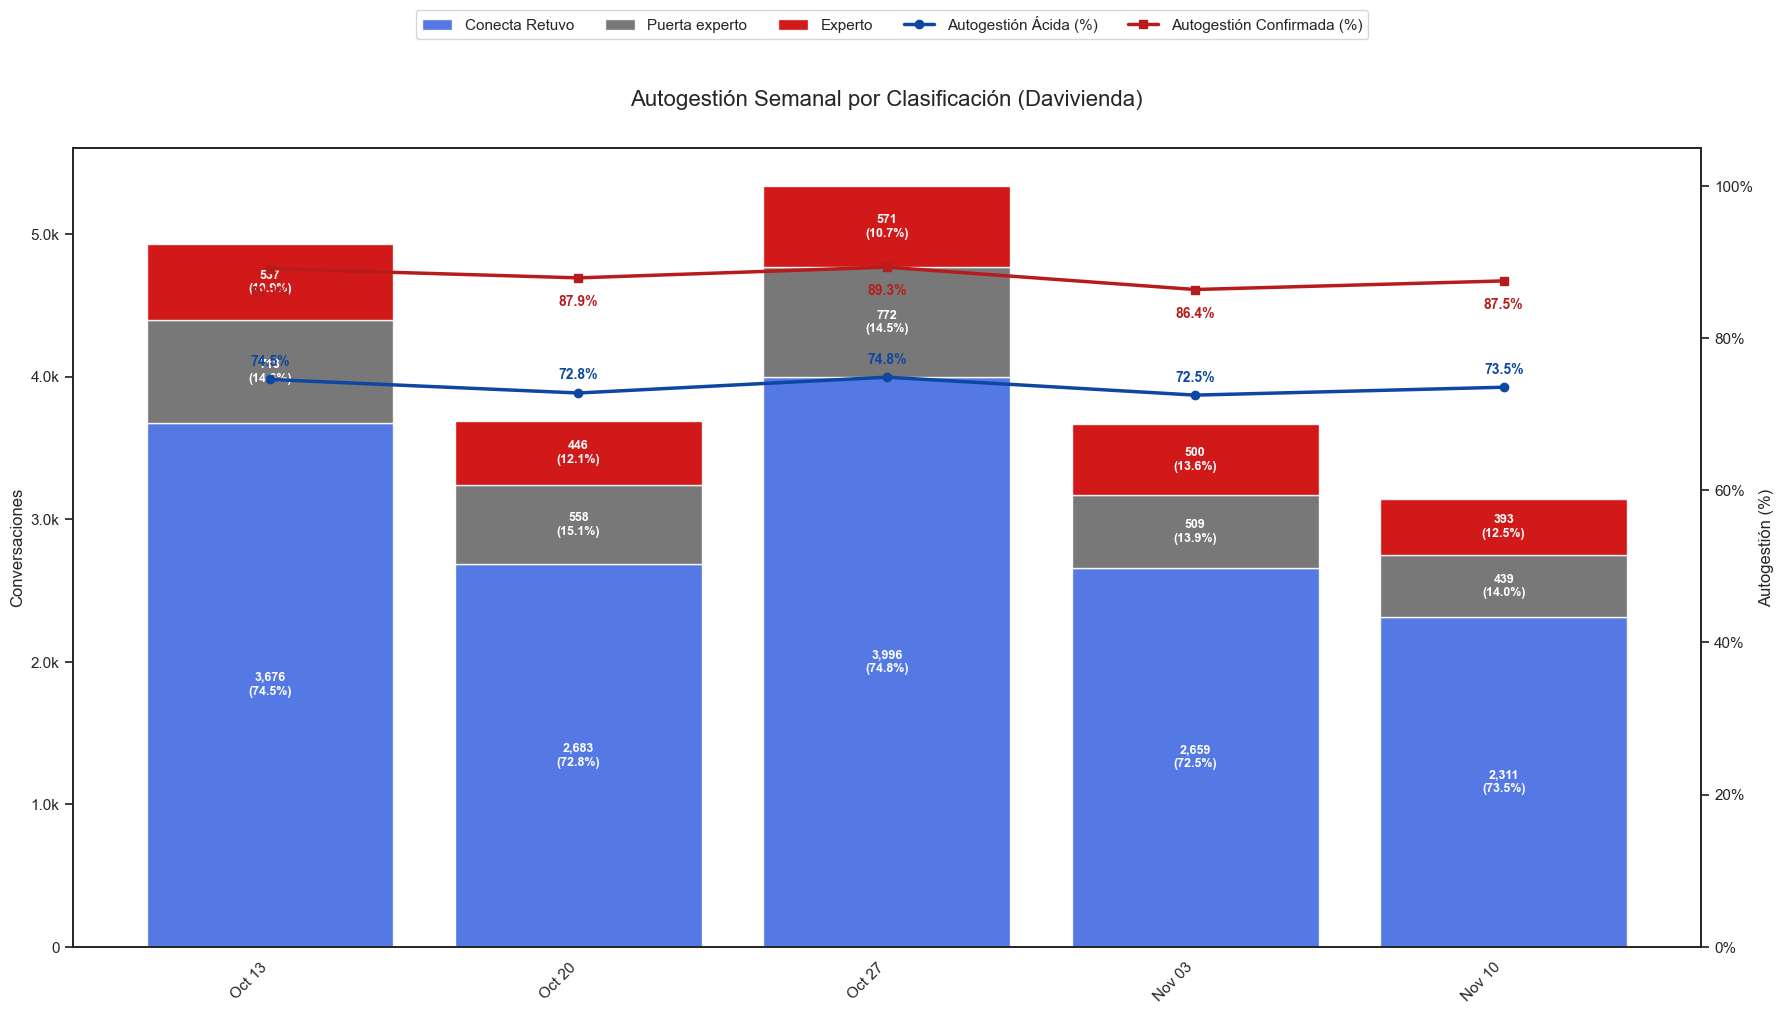

In [50]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

df_autog = df_merged_final.copy()
df_autog["fecha"] = pd.to_datetime(df_autog["fecha"], errors="coerce")

# 1. Agrupar por conversación para definir la nueva clasificación
df_conv_clasif = (
    df_autog.groupby(["fk_tbl_conversaciones_conecta2"])
    .agg(
        week_start=("fecha", lambda d: (d.min().normalize() - pd.to_timedelta(d.min().weekday(), unit="D"))),
        motivo_experto_flag=("motivo_experto", lambda s: s.notna().any()),
        flg_experto_sum=("flg_experto", "sum"),
    )
    .reset_index()
)

# 2. Aplicar la lógica de 3 grupos
df_conv_clasif["clasificacion"] = np.select(
    [
        ~df_conv_clasif["motivo_experto_flag"],
        df_conv_clasif["motivo_experto_flag"] & (df_conv_clasif["flg_experto_sum"] == 0),
        df_conv_clasif["motivo_experto_flag"] & (df_conv_clasif["flg_experto_sum"] >= 1),
    ],
    ["Conecta Retuvo", "Puerta experto", "Experto"],
    default="Otro",
)

# 3. Resumir por semana
resumen_semanal = (
    df_conv_clasif.groupby(["week_start", "clasificacion"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
    .sort_values("week_start")
)

# Asegurar que todas las columnas existan
for col in ["Conecta Retuvo", "Puerta experto", "Experto"]:
    if col not in resumen_semanal.columns:
        resumen_semanal[col] = 0

resumen_semanal["total_conversaciones"] = (
    resumen_semanal["Conecta Retuvo"]
    + resumen_semanal["Puerta experto"]
    + resumen_semanal["Experto"]
)
# --- Calcular ambas métricas de autogestión ---
resumen_semanal["autogestion_acida"] = (
    resumen_semanal["Conecta Retuvo"] / resumen_semanal["total_conversaciones"] * 100
).round(2)
resumen_semanal["autogestion_confirmada"] = (
    (resumen_semanal["Conecta Retuvo"] + resumen_semanal["Puerta experto"]) / resumen_semanal["total_conversaciones"] * 100
).round(2)


# --- Inicio del Gráfico ---
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(18, 10))

x = np.arange(len(resumen_semanal))
bar_labels = ["Conecta Retuvo", "Puerta experto", "Experto"]
# --- Paleta de colores Davivienda ---
color_map = {
    "Conecta Retuvo": "#4169E1",  # Azul Rey
    "Puerta experto": "#696969",  # Gris Oscuro
    "Experto": "#CC0000",         # Rojo
}
line_color_acida = "#0D47A1" # Azul oscuro
line_color_confirmada = "#B71C1C" # Rojo oscuro

# --- Gráfico de Barras Apiladas ---
bottom = np.zeros(len(resumen_semanal))
bar_containers = []
for label in bar_labels:
    values = resumen_semanal[label].to_numpy()
    bars = ax.bar(x, values, bottom=bottom, label=label, color=color_map[label], alpha=0.9)
    bar_containers.append((bars, values))
    bottom += values

# Anotaciones dentro de las barras
totals = resumen_semanal['total_conversaciones'].to_numpy()
for bars, values in bar_containers:
    for idx, bar in enumerate(bars):
        height = values[idx]
        if height > 0 and totals[idx] > 0:
            pct = height / totals[idx] * 100
            ax.annotate(
                f'{height:,.0f}\n({pct:.1f}%)',
                (bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                ha='center', va='center', color='white', fontsize=9, fontweight='bold'
            )

# --- Formato Eje X ---
ax.set_xticks(x)
ax.set_xticklabels(resumen_semanal['week_start'].dt.strftime('%b %d'), rotation=45, ha='right', fontsize=11)
ax.set_xlabel('') # Eliminar etiqueta del eje X

# --- Formato Eje Y Izquierdo ---
ax.set_ylabel('Conversaciones', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v/1000:.1f}k' if v >= 1000 else f'{v:,.0f}'))
ax.grid(False) # Eliminar grid

# --- Eje Y Derecho para las líneas ---
ax2 = ax.twinx()
# Línea 1: Autogestión Ácida
ax2.plot(
    x,
    resumen_semanal["autogestion_acida"],
    color=line_color_acida,
    marker='o',
    linewidth=2.5,
    label='Autogestión Ácida (%)'
)
# Línea 2: Autogestión Confirmada
ax2.plot(
    x,
    resumen_semanal["autogestion_confirmada"],
    color=line_color_confirmada,
    marker='s', # Cuadrado para diferenciar
    linewidth=2.5,
    label='Autogestión Confirmada (%)'
)

# Anotaciones en la línea Ácida
for xi, yi in zip(x, resumen_semanal["autogestion_acida"]):
    ax2.annotate(
        f'{yi:.1f}%', (xi, yi), textcoords='offset points',
        xytext=(0, 10), ha='center', color=line_color_acida, fontsize=10, fontweight='bold'
    )

# Anotaciones en la línea Confirmada
for xi, yi in zip(x, resumen_semanal["autogestion_confirmada"]):
    ax2.annotate(
        f'{yi:.1f}%', (xi, yi), textcoords='offset points',
        xytext=(0, -20), ha='center', color=line_color_confirmada, fontsize=10, fontweight='bold'
    )


# --- Formato Eje Y Derecho ---
ax2.set_ylabel('Autogestión (%)', fontsize=12)
ax2.set_ylim(0, 105)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f'{v:.0f}%'))
ax2.grid(False) # Eliminar grid

# --- Leyenda y Título ---
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    handles1 + handles2, labels1 + labels2,
    loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=5, fontsize=11
)

plt.title("Autogestión Semanal por Clasificación (Davivienda)", fontsize=16, pad=30)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Ajustar para que el título y leyenda no se corten
plt.show()


In [51]:
# Exportar los datos del gráfico a un archivo CSV
output_filename = 'resumen_semanal_autogestion.csv'
resumen_semanal.to_csv(output_filename, index=False, sep=';', decimal='.')

print(f"Los datos del gráfico se han exportado a '{output_filename}'")

Los datos del gráfico se han exportado a 'resumen_semanal_autogestion.csv'


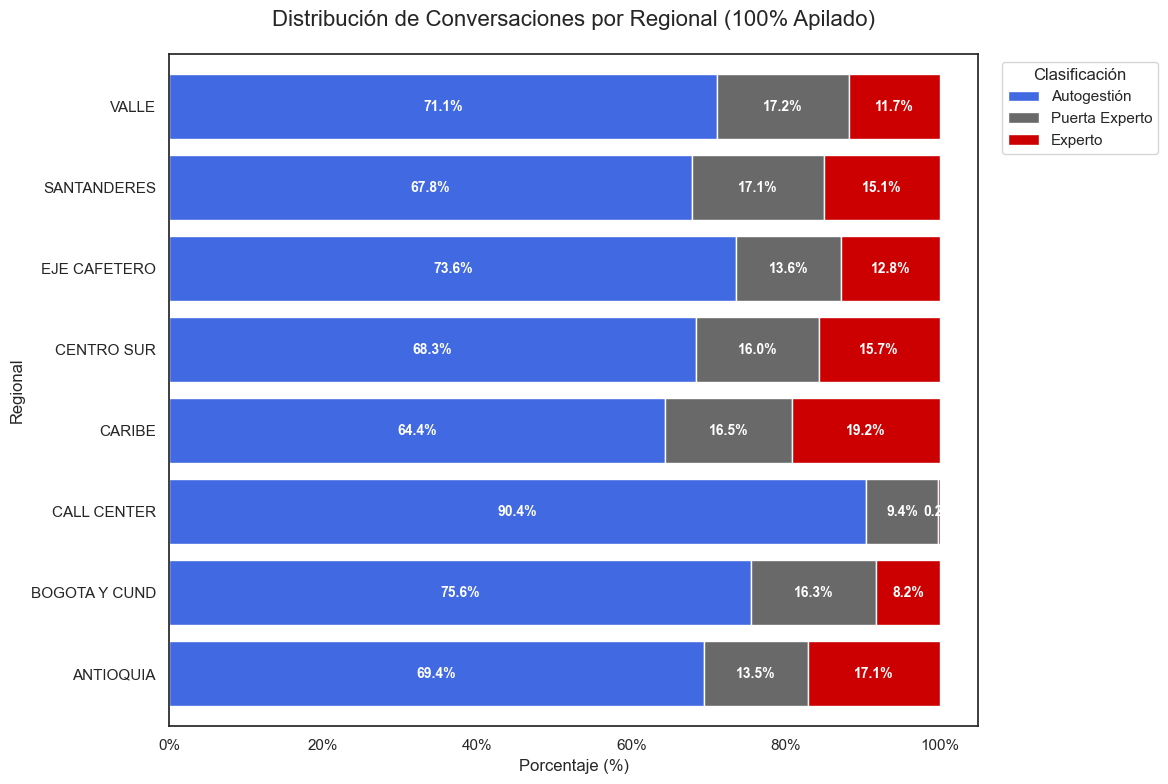

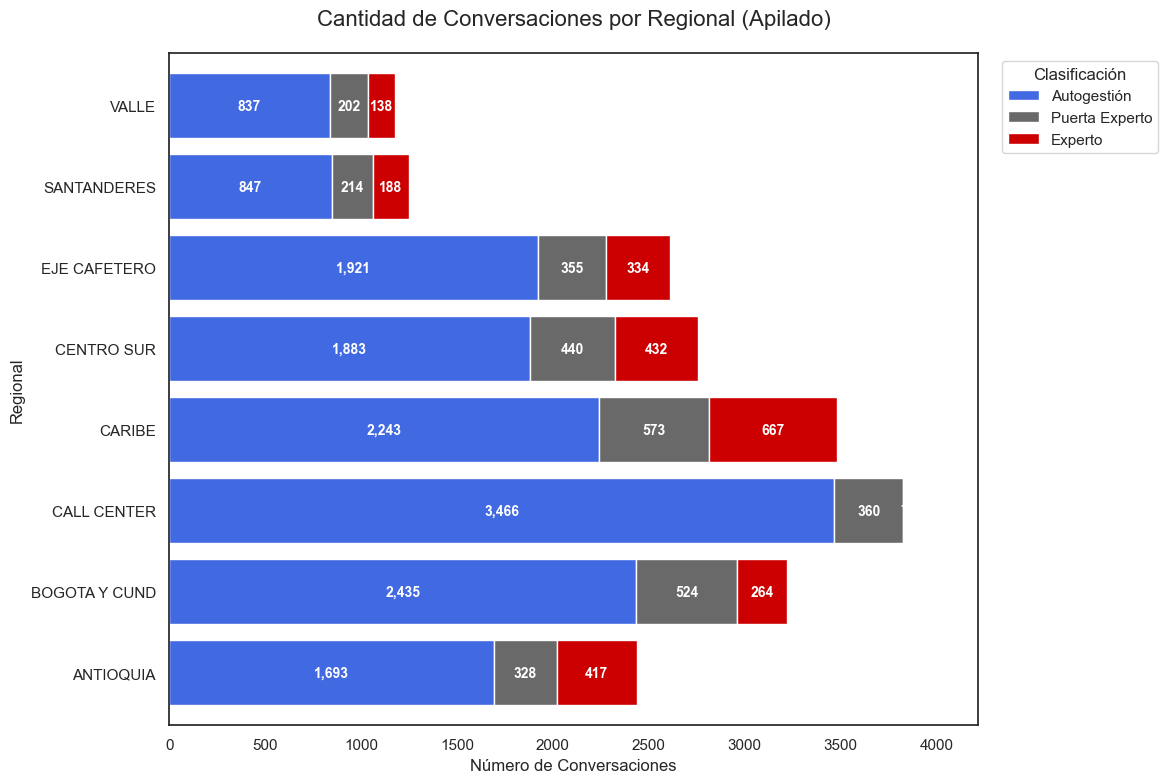

In [52]:
# --- Preparación de Datos para Gráficos ---

# 1. Agrupar por conversación para obtener el estado final
df_conv_estado = df_merged_final.groupby('fk_tbl_conversaciones_conecta2').agg(
    flg_experto_final=('flg_experto', 'max'),
    motivo_experto_presente=('motivo_experto', lambda x: x.notna().any()),
    regional=('REGIONAL', 'first')
).reset_index()

# 2. Aplicar la lógica de clasificación
def clasificar_conversacion(row):
    if row['flg_experto_final'] == 1:
        return 'Experto'
    elif row['flg_experto_final'] == 0 and row['motivo_experto_presente']:
        return 'Puerta Experto'
    else: # flg_experto_final == 0 and not motivo_experto_presente
        return 'Autogestión'

df_conv_estado['clasificacion'] = df_conv_estado.apply(clasificar_conversacion, axis=1)

# 3. Crear tabla de contingencia (crosstab) para los conteos
conteo_regional = pd.crosstab(df_conv_estado['regional'], df_conv_estado['clasificacion'])

# Reordenar columnas para el gráfico
column_order = ['Autogestión', 'Puerta Experto', 'Experto']
conteo_regional = conteo_regional.reindex(columns=column_order, fill_value=0)


# --- Gráfico 1: Barras Horizontales Agrupadas al 100% ---

# Normalizar los datos para obtener porcentajes
conteo_percent = conteo_regional.div(conteo_regional.sum(axis=1), axis=0) * 100

# Paleta de colores
color_map = {
    "Autogestión": "#4169E1",  # Azul Rey
    "Puerta Experto": "#696969",  # Gris Oscuro
    "Experto": "#CC0000",         # Rojo
}

# Crear el gráfico
ax1 = conteo_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map.get(x, '#333333') for x in conteo_percent.columns],
    width=0.8
)

# Añadir anotaciones de porcentaje dentro de las barras
for container in ax1.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax1.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=10,
                fontweight='bold'
            )

ax1.set_title('Distribución de Conversaciones por Regional (100% Apilado)', fontsize=16, pad=20)
ax1.set_xlabel('Porcentaje (%)')
ax1.set_ylabel('Regional')
ax1.legend(title='Clasificación', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Gráfico 2: Barras Horizontales Apiladas con Cantidades ---

# Crear el gráfico de conteos apilado
ax2 = conteo_regional.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map.get(x, '#333333') for x in conteo_regional.columns],
    width=0.8
)

# Añadir anotaciones de conteo dentro de las barras
for container in ax2.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax2.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',
                ha='center',
                va='center',
                color='white',
                fontsize=10,
                fontweight='bold'
            )

ax2.set_title('Cantidad de Conversaciones por Regional (Apilado)', fontsize=16, pad=20)
ax2.set_xlabel('Número de Conversaciones')
ax2.set_ylabel('Regional')
ax2.legend(title='Clasificación', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.margins(x=0.1) # Añadir margen para que las etiquetas no se corten
ax2.margins(x=0.1) # Añadir margen para que las etiquetas no se corten
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

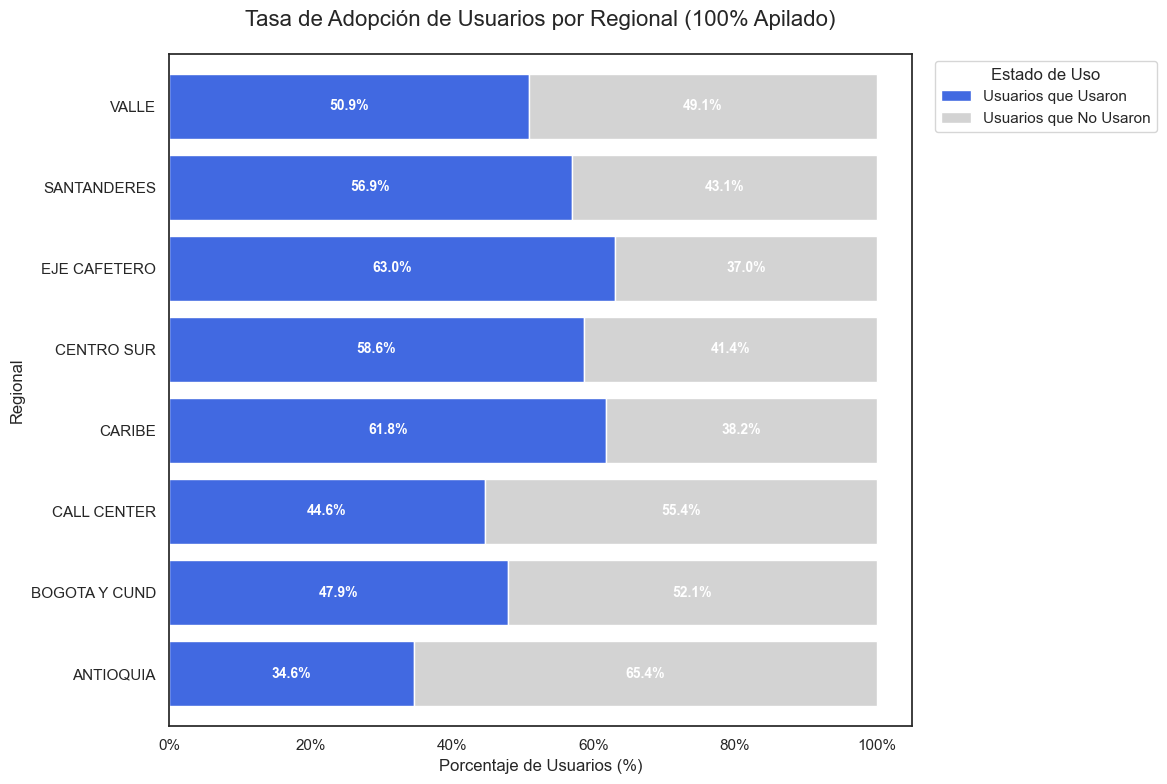

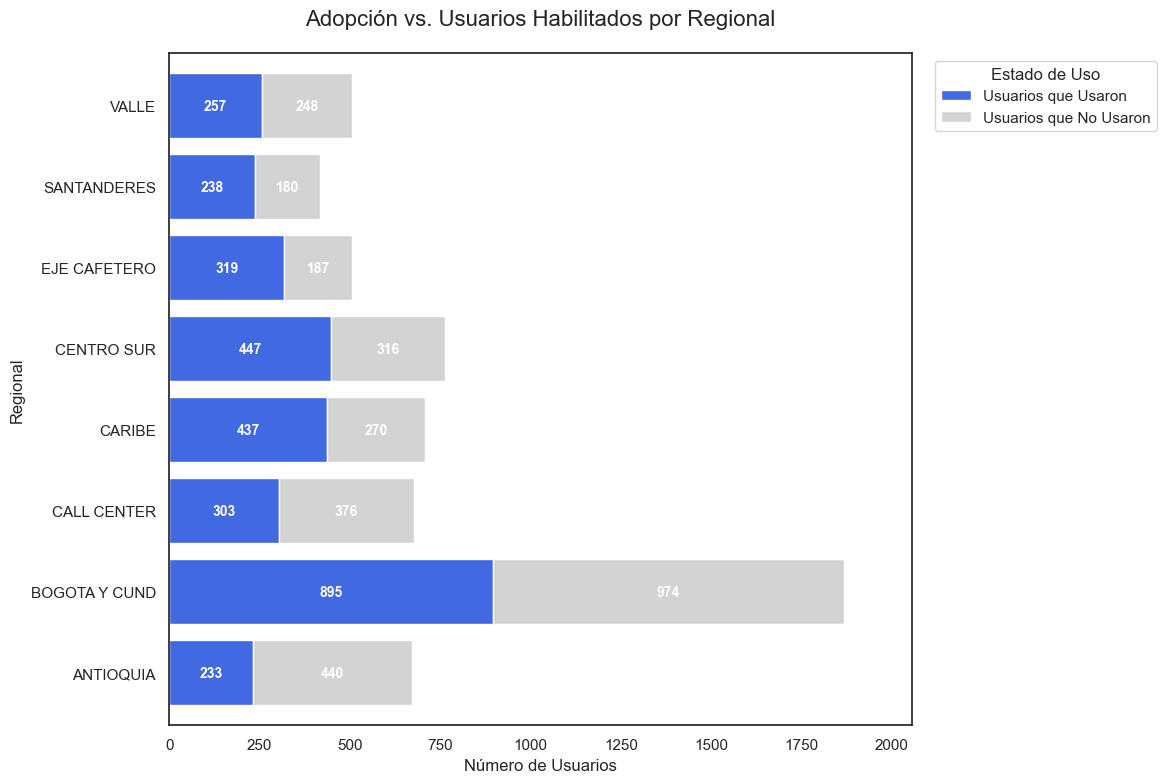

Los datos de adopción de usuarios por regional se han exportado a 'adopcion_usuarios_regional.csv'


,REGIONAL,Usuarios Habilitados,Usuarios que Usaron,Usuarios que No Usaron,Tasa_Adopcion_%
0,ANTIOQUIA,673,233,440,34.62
1,BOGOTA Y CUND,1869,895,974,47.89
2,CALL CENTER,679,303,376,44.62
3,CARIBE,707,437,270,61.81
4,CENTRO SUR,763,447,316,58.58
5,EJE CAFETERO,506,319,187,63.04
6,SANTANDERES,418,238,180,56.94
7,VALLE,505,257,248,50.89


In [53]:
# --- Preparación de Datos para Gráfico de Adopción de Usuarios ---

# 1. Contar usuarios únicos que usaron la herramienta por regional
usuarios_activos = df_merged_final.groupby('REGIONAL')['correo'].nunique().reset_index()
usuarios_activos.rename(columns={'correo': 'Usuarios que Usaron'}, inplace=True)

# 2. Contar total de usuarios habilitados por regional
usuarios_habilitados = regional_concat.groupby('REGIONAL')['Correo electrónico'].nunique().reset_index()
usuarios_habilitados.rename(columns={'Correo electrónico': 'Usuarios Habilitados'}, inplace=True)

# 3. Unir ambos dataframes
df_adopcion = pd.merge(usuarios_habilitados, usuarios_activos, on='REGIONAL', how='left')
df_adopcion['Usuarios que Usaron'] = df_adopcion['Usuarios que Usaron'].fillna(0).astype(int)

# 4. Calcular usuarios que no han usado la herramienta
df_adopcion['Usuarios que No Usaron'] = df_adopcion['Usuarios Habilitados'] - df_adopcion['Usuarios que Usaron']

# 5. Preparar DataFrame para los gráficos
conteo_adopcion = df_adopcion.set_index('REGIONAL')[['Usuarios que Usaron', 'Usuarios que No Usaron']]


# --- Gráfico 1: Adopción de Usuarios por Regional (100% Apilado) ---

# Normalizar para obtener porcentajes
conteo_adopcion_percent = conteo_adopcion.div(conteo_adopcion.sum(axis=1), axis=0) * 100

# Paleta de colores
color_map_adopcion = {
    "Usuarios que Usaron": "#4169E1",  # Azul Rey
    "Usuarios que No Usaron": "#D3D3D3", # Gris Claro
}

ax1 = conteo_adopcion_percent.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map_adopcion.get(x) for x in conteo_adopcion_percent.columns],
    width=0.8
)

# Anotaciones de porcentaje
for container in ax1.containers:
    for bar in container:
        width = bar.get_width()
        if width > 5:  # Solo mostrar etiqueta si el espacio es suficiente
            ax1.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:.1f}%',
                ha='center', va='center', color='white', fontsize=10, fontweight='bold'
            )

ax1.set_title('Tasa de Adopción de Usuarios por Regional (100% Apilado)', fontsize=16, pad=20)
ax1.set_xlabel('Porcentaje de Usuarios (%)')
ax1.set_ylabel('Regional')
ax1.legend(title='Estado de Uso', bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Gráfico 2: Cantidad de Usuarios por Regional (Apilado) ---

ax2 = conteo_adopcion.plot(
    kind='barh',
    stacked=True,
    figsize=(14, 8),
    color=[color_map_adopcion.get(x) for x in conteo_adopcion.columns],
    width=0.8
)

# Anotaciones de conteo
for container in ax2.containers:
    for bar in container:
        width = bar.get_width()
        if width > 0:
            ax2.text(
                bar.get_x() + width / 2,
                bar.get_y() + bar.get_height() / 2,
                f'{width:,.0f}',
                ha='center', va='center', color='white', fontsize=10, fontweight='bold'
            )

ax2.set_title('Adopción vs. Usuarios Habilitados por Regional', fontsize=16, pad=20)
ax2.set_xlabel('Número de Usuarios')
ax2.set_ylabel('Regional')
ax2.legend(title='Estado de Uso', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.margins(x=0.1)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()


# --- Exportar datos a CSV ---
df_export_adopcion = df_adopcion.copy()
df_export_adopcion['Tasa_Adopcion_%'] = (df_export_adopcion['Usuarios que Usaron'] / df_export_adopcion['Usuarios Habilitados'] * 100).round(2)

output_filename_adopcion = 'adopcion_usuarios_regional.csv'
df_export_adopcion.to_csv(output_filename_adopcion, index=False, sep=';', decimal='.')

print(f"Los datos de adopción de usuarios por regional se han exportado a '{output_filename_adopcion}'")
display(df_export_adopcion)

In [54]:
# --- Exportar datos de los gráficos a CSV ---

# Combinar conteos y porcentajes en un solo DataFrame
df_exportacion_regional = conteo_regional.copy()
df_exportacion_regional = df_exportacion_regional.join(conteo_percent.rename(columns=lambda x: f"{x}_%"))

# Añadir una columna con el total de conversaciones por regional
df_exportacion_regional['Total_Conversaciones'] = df_exportacion_regional[['Autogestión', 'Puerta Experto', 'Experto']].sum(axis=1)

# Resetear el índice para que 'regional' sea una columna
df_exportacion_regional = df_exportacion_regional.reset_index()

# Reordenar columnas para mayor claridad
column_order_export = [
    'regional',
    'Autogestión',
    'Puerta Experto',
    'Experto',
    'Total_Conversaciones',
    'Autogestión_%',
    'Puerta Experto_%',
    'Experto_%'
]
df_exportacion_regional = df_exportacion_regional[column_order_export]


# Guardar en archivo CSV
output_filename_regional = 'distribucion_regional.csv'
df_exportacion_regional.to_csv(output_filename_regional, index=False, sep=';', decimal='.')

print(f"Los datos de los gráficos por regional se han exportado a '{output_filename_regional}'")
display(df_exportacion_regional)

Los datos de los gráficos por regional se han exportado a 'distribucion_regional.csv'


clasificacion,regional,Autogestión,Puerta Experto,Experto,Total_Conversaciones,Autogestión_%,Puerta Experto_%,Experto_%
0,ANTIOQUIA,1693,328,417,2438,69.442166,13.453651,17.104184
1,BOGOTA Y CUND,2435,524,264,3223,75.550729,16.258145,8.191126
2,CALL CENTER,3466,360,7,3833,90.425254,9.392121,0.182625
3,CARIBE,2243,573,667,3483,64.398507,16.451335,19.150158
4,CENTRO SUR,1883,440,432,2755,68.348457,15.970962,15.680581
5,EJE CAFETERO,1921,355,334,2610,73.601533,13.601533,12.796935
6,SANTANDERES,847,214,188,1249,67.814251,17.133707,15.052042
7,VALLE,837,202,138,1177,71.112999,17.162277,11.724724


### 5.1 Comparación Langfuse vs Conversaciones BD

Comparación diaria entre:
- **Trazas Langfuse** (`sessionId`): Ejecuciones registradas del sistema de IA
- **Conversaciones BD** (`fk_tbl_conversaciones_conecta2`): Interacciones almacenadas en base de datos

Objetivo: Identificar correlación entre ambas fuentes y detectar posibles gaps en trazabilidad.

In [55]:
# ===== COMPARACIÓN DIARIA: LANGFUSE VS BD =====
print("="*80)
print("COMPARACIÓN DIARIA: TRAZAS LANGFUSE VS CONVERSACIONES BD")
print("="*80)

# 1. Preparar datos de Langfuse (por día)
df_langfuse_dia = df_langfuse.copy()
df_langfuse_dia['fecha'] = df_langfuse_dia['timestamp'].dt.date

langfuse_por_dia = df_langfuse_dia.groupby('fecha').agg(
    sessionId_unicos=('sessionId', 'nunique'),
    trazas_totales=('sessionId', 'size'),
    sesiones_con_error=('has_error', 'sum')
).reset_index()

print(f"\n📊 Rango de fechas en Langfuse:")
print(f"  Desde: {langfuse_por_dia['fecha'].min()}")
print(f"  Hasta: {langfuse_por_dia['fecha'].max()}")
print(f"  Total días: {len(langfuse_por_dia)}")

# 2. Preparar datos de BD (por día)
df_bd_dia = df_merged_final.copy()
df_bd_dia['fecha'] = df_bd_dia['fecha_hora_inicio'].dt.date

bd_por_dia = df_bd_dia.groupby('fecha').agg(
    conversaciones_totales=('fk_tbl_conversaciones_conecta2', 'nunique'),
    interacciones_totales=('fk_tbl_conversaciones_conecta2', 'size'),
    conversaciones_con_respuesta=('respuesta', lambda x: x.notna().sum()),
    conversaciones_sin_respuesta=('respuesta', lambda x: x.isna().sum())
).reset_index()

# Calcular conversaciones únicas con/sin respuesta a nivel de conversación
conversaciones_por_estado = df_bd_dia.groupby(['fk_tbl_conversaciones_conecta2', 'fecha']).agg(
    tiene_respuesta=('respuesta', lambda x: x.notna().any())
).reset_index()

conv_con_respuesta = conversaciones_por_estado[conversaciones_por_estado['tiene_respuesta']].groupby('fecha').size()
conv_sin_respuesta = conversaciones_por_estado[~conversaciones_por_estado['tiene_respuesta']].groupby('fecha').size()

bd_por_dia = bd_por_dia.merge(
    conv_con_respuesta.reset_index(name='conv_unicas_con_respuesta'),
    on='fecha',
    how='left'
).merge(
    conv_sin_respuesta.reset_index(name='conv_unicas_sin_respuesta'),
    on='fecha',
    how='left'
)

bd_por_dia['conv_unicas_con_respuesta'] = bd_por_dia['conv_unicas_con_respuesta'].fillna(0).astype(int)
bd_por_dia['conv_unicas_sin_respuesta'] = bd_por_dia['conv_unicas_sin_respuesta'].fillna(0).astype(int)

print(f"\n📊 Rango de fechas en BD:")
print(f"  Desde: {bd_por_dia['fecha'].min()}")
print(f"  Hasta: {bd_por_dia['fecha'].max()}")
print(f"  Total días: {len(bd_por_dia)}")

# 3. Merge de ambos dataframes por fecha
comparacion = pd.merge(
    langfuse_por_dia,
    bd_por_dia,
    on='fecha',
    how='outer',
    suffixes=('_langfuse', '_bd')
)

# Rellenar NaN con 0 para días sin datos
comparacion = comparacion.fillna(0)

# Calcular diferencias y ratios
comparacion['diff_conversaciones'] = comparacion['conversaciones_totales'] - comparacion['sessionId_unicos']
comparacion['ratio_langfuse_bd'] = np.where(
    comparacion['conversaciones_totales'] > 0,
    comparacion['sessionId_unicos'] / comparacion['conversaciones_totales'],
    0
)

# Ordenar por fecha
comparacion = comparacion.sort_values('fecha')

print(f"\n📈 Resumen comparativo:")
print(f"  Días con datos en ambas fuentes: {(comparacion['sessionId_unicos'] > 0) & (comparacion['conversaciones_totales'] > 0).sum()}")
print(f"  Días solo en Langfuse: {((comparacion['sessionId_unicos'] > 0) & (comparacion['conversaciones_totales'] == 0)).sum()}")
print(f"  Días solo en BD: {((comparacion['sessionId_unicos'] == 0) & (comparacion['conversaciones_totales'] > 0)).sum()}")

print(f"\n📊 Totales generales:")
print(f"  SessionId únicos (Langfuse): {comparacion['sessionId_unicos'].sum():,.0f}")
print(f"  Conversaciones únicas (BD): {comparacion['conversaciones_totales'].sum():,.0f}")
print(f"  Diferencia: {comparacion['diff_conversaciones'].sum():,.0f}")
print(f"  Ratio promedio Langfuse/BD: {comparacion['ratio_langfuse_bd'].mean():.2%}")

# Mostrar primeras y últimas filas
print(f"\n📋 Primeras 10 filas de comparación:")
print(comparacion.head(10).to_string(index=False))

print(f"\n📋 Últimas 10 filas de comparación:")
print(comparacion.tail(10).to_string(index=False))

COMPARACIÓN DIARIA: TRAZAS LANGFUSE VS CONVERSACIONES BD

📊 Rango de fechas en Langfuse:
  Desde: 2025-10-11
  Hasta: 2025-11-13
  Total días: 34

📊 Rango de fechas en BD:
  Desde: 2025-10-13
  Hasta: 2025-11-13
  Total días: 32

📈 Resumen comparativo:
  Días con datos en ambas fuentes: 0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
Name: sessionId_unicos, dtype: bool
  Días solo en Langfuse: 2
  Días solo en BD: 0

📊 Totales generales:
  SessionId únicos (Langfuse): 36,493
  Conversaciones únicas (BD): 20,768
  Diferencia: -15,725
  Ratio promedio Langfuse/BD: 150.67%

📋 Primeras 10 filas de comparación:
     fecha  sessionId_unic

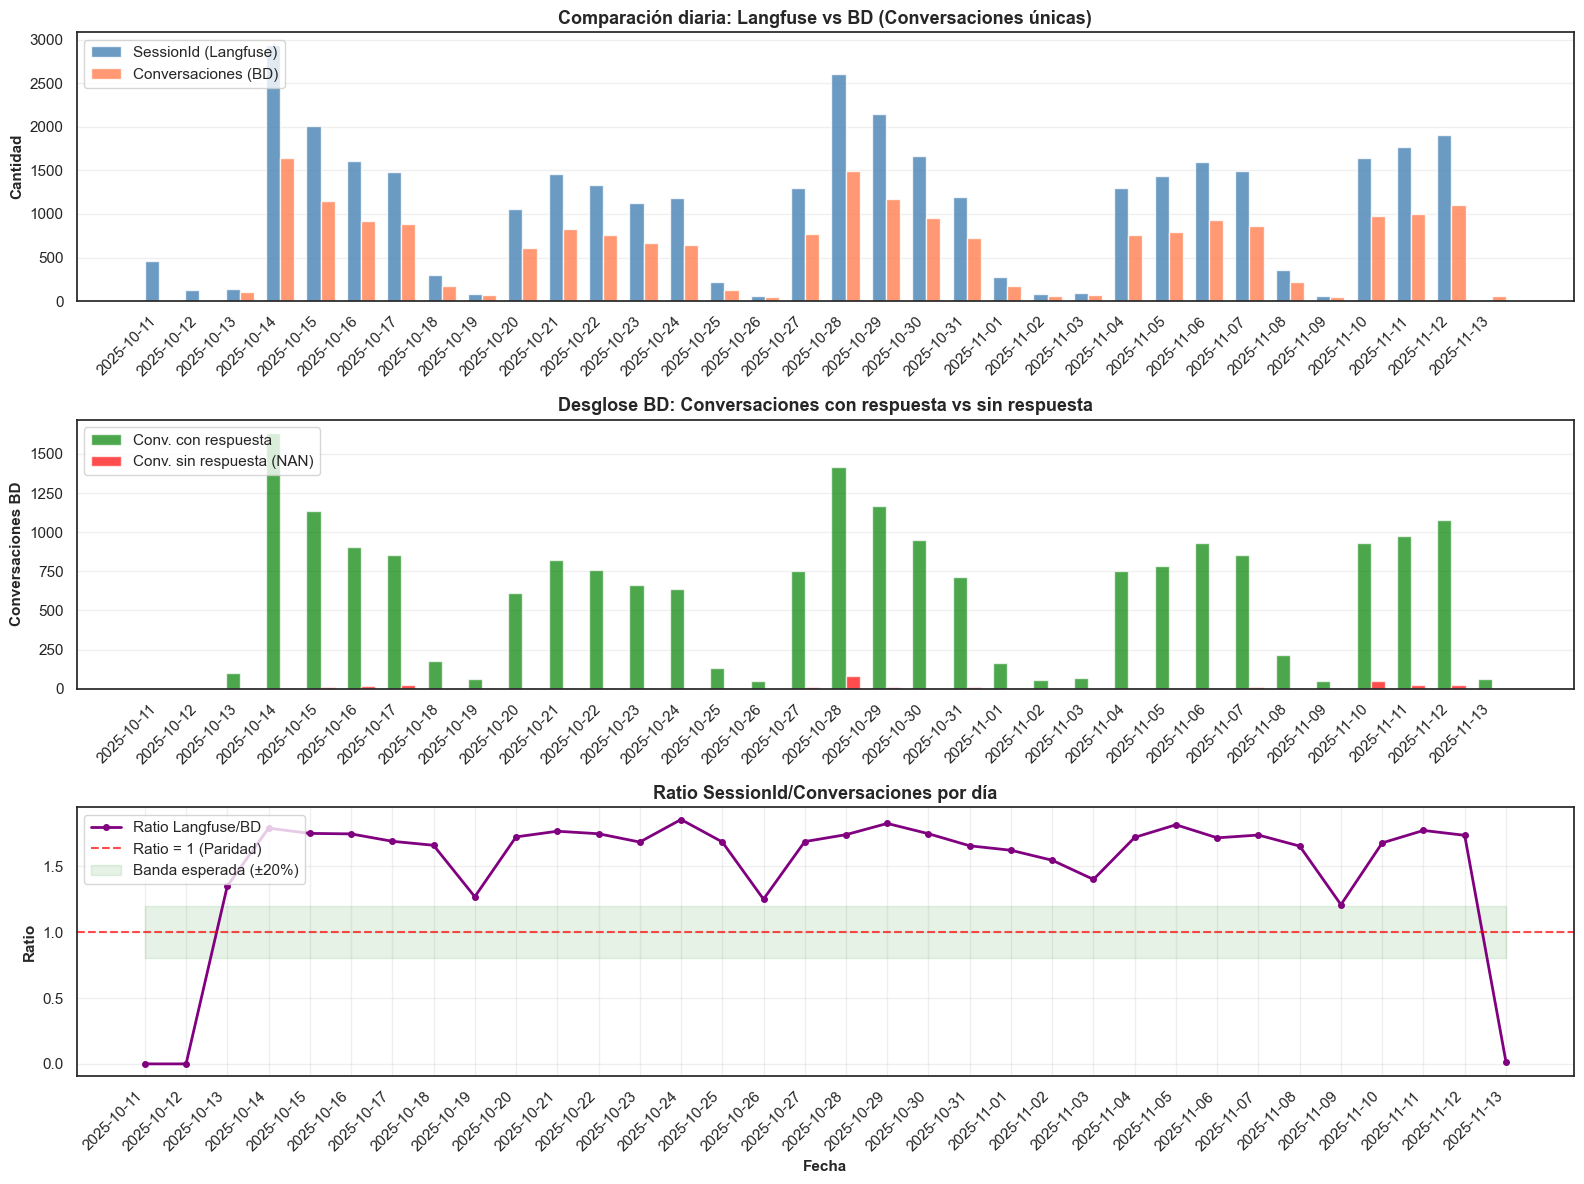


📊 Análisis del Ratio Langfuse/BD:
  Promedio: 150.67%
  Mediana: 168.83%
  Desviación estándar: 50.18%
  Mínimo: 0.00%
  Máximo: 185.47%


In [57]:
# ===== VISUALIZACIÓN COMPARATIVA =====

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Filtrar solo fechas con datos en al menos una fuente
comparacion_plot = comparacion[(comparacion['sessionId_unicos'] > 0) | (comparacion['conversaciones_totales'] > 0)].copy()

# Gráfico 1: Comparación de volúmenes totales
ax1 = axes[0]
width = 0.35
x = np.arange(len(comparacion_plot))

bars1 = ax1.bar(x - width/2, comparacion_plot['sessionId_unicos'], width, 
                label='SessionId (Langfuse)', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, comparacion_plot['conversaciones_totales'], width,
                label='Conversaciones (BD)', color='coral', alpha=0.8)

ax1.set_ylabel('Cantidad', fontsize=11, fontweight='bold')
ax1.set_title('Comparación diaria: Langfuse vs BD (Conversaciones únicas)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# Mostrar solo cada N fechas para evitar saturación
step = max(1, len(comparacion_plot) // 20)
ax1.set_xticks(x[::step])
ax1.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

# Gráfico 2: Desglose BD (Con respuesta vs Sin respuesta)
ax2 = axes[1]
bars3 = ax2.bar(x - width/2, comparacion_plot['conv_unicas_con_respuesta'], width,
                label='Conv. con respuesta', color='green', alpha=0.7)
bars4 = ax2.bar(x + width/2, comparacion_plot['conv_unicas_sin_respuesta'], width,
                label='Conv. sin respuesta (NAN)', color='red', alpha=0.7)

ax2.set_ylabel('Conversaciones BD', fontsize=11, fontweight='bold')
ax2.set_title('Desglose BD: Conversaciones con respuesta vs sin respuesta', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticks(x[::step])
ax2.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

# Gráfico 3: Ratio Langfuse/BD
ax3 = axes[2]
line = ax3.plot(x, comparacion_plot['ratio_langfuse_bd'], 
                marker='o', color='purple', linewidth=2, markersize=4, label='Ratio Langfuse/BD')
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Ratio = 1 (Paridad)')
ax3.fill_between(x, 0.8, 1.2, color='green', alpha=0.1, label='Banda esperada (±20%)')

ax3.set_ylabel('Ratio', fontsize=11, fontweight='bold')
ax3.set_xlabel('Fecha', fontsize=11, fontweight='bold')
ax3.set_title('Ratio SessionId/Conversaciones por día', fontsize=13, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(axis='both', alpha=0.3)
ax3.set_xticks(x[::step])
ax3.set_xticklabels([str(d) for d in comparacion_plot['fecha'].iloc[::step]], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Estadísticas del ratio
print(f"\n📊 Análisis del Ratio Langfuse/BD:")
print(f"  Promedio: {comparacion_plot['ratio_langfuse_bd'].mean():.2%}")
print(f"  Mediana: {comparacion_plot['ratio_langfuse_bd'].median():.2%}")
print(f"  Desviación estándar: {comparacion_plot['ratio_langfuse_bd'].std():.2%}")
print(f"  Mínimo: {comparacion_plot['ratio_langfuse_bd'].min():.2%}")
print(f"  Máximo: {comparacion_plot['ratio_langfuse_bd'].max():.2%}")

In [62]:
import nltk

# Descargar la lista de stopwords en español la primera vez que se usa
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

from nltk.corpus import stopwords

# --- FUNCIÓN DE NORMALIZACIÓN ---
def normalizar_pregunta(texto):
    """
    Aplica una serie de pasos de limpieza y normalización a un texto.
    """
    # 1. Convertir a minúsculas
    texto = texto.lower()
    
    # 2. Eliminar acentos
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    
    # 3. Eliminar signos de puntuación y caracteres especiales
    texto = re.sub(r'[^\w\s]', '', texto)
    
    # 4. Eliminar stopwords
    stop_words = set(stopwords.words('spanish'))
    palabras = texto.split()
    palabras_filtradas = [palabra for palabra in palabras if palabra not in stop_words]
    texto = ' '.join(palabras_filtradas)
    
    # 5. Eliminar espacios extra (ya se maneja con el split/join, pero es una buena práctica)
    texto = ' '.join(texto.split())
    
    return texto

# --- APLICAR LA NORMALIZACIÓN Y CONTAR ---
df = df_merged_final.copy()

# Aplicamos la función a nuestra columna de preguntas
df['pregunta_normalizada'] = df['pregunta'].apply(normalizar_pregunta)

# ¡Aquí está la magia! Contamos las ocurrencias de las preguntas ya normalizadas
conteo_preguntas = df['pregunta_normalizada'].value_counts()

print("--- DataFrame con preguntas normalizadas ---")
print("\n" + "="*40 + "\n")
print("--- Conteo de las preguntas más frecuentes ---")
display(conteo_preguntas)

--- DataFrame con preguntas normalizadas ---


--- Conteo de las preguntas más frecuentes ---


pregunta_normalizada
simulador cdt                                           226
modulo embargos                                          85
levantamiento hipoteca                                   59
sobrante libranza                                        54
qr interoperable                                         52
                                                       ... 
documentos hacer sucecion credito hipotecario             1
feanquicias tarjeta creidto cuentan acceso salas vip      1
quiero base datos oficna cambie dolares                   1
quiwero conoce cuales oficna cambie dolares               1
certificacion gravament                                   1
Name: count, Length: 26837, dtype: int64

In [65]:
conteo_preguntas.head(20)

pregunta_normalizada
simulador cdt               226
modulo embargos              85
levantamiento hipoteca       59
sobrante libranza            54
qr interoperable             52
tasas tarifas                51
necesito experto             50
novedades express            46
derecho peticion             46
radicar derecho peticion     44
conecta credito              42
base colombia                37
si                           35
bloqueo k                    35
sapli cartera                33
simulador vivienda           32
registro dispositivo         30
visita ocular                28
cuenta pension               27
cuanto cuota credito         27
Name: count, dtype: int64

## Clasificación IA (Gestionada vs. NO Gestionada)

In [65]:
import os
import json
import pandas as pd
import time
from google.oauth2 import service_account
from google.api_core import exceptions
import vertexai
from vertexai.generative_models import GenerativeModel

# --- 1. CONFIGURACIÓN DE AUTENTICACIÓN Y MODELO CON CUENTA DE SERVICIO ---

# Nombre del archivo de la cuenta de servicio
SERVICE_ACCOUNT_FILE = 'comusoporte-desarrollo-319e345bb885.json'

# Carga las credenciales desde el archivo JSON
try:
    credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE)
    print("Credenciales de cuenta de servicio cargadas exitosamente.")
except FileNotFoundError:
    raise RuntimeError(f"El archivo '{SERVICE_ACCOUNT_FILE}' no se encontró. Asegúrate de que esté en el mismo directorio.")

# Extrae el project_id del archivo de credenciales
with open(SERVICE_ACCOUNT_FILE, 'r') as f:
    project_id = json.load(f).get('project_id')

if not project_id:
    raise RuntimeError("El 'project_id' no se encontró en el archivo de la cuenta de servicio.")

# TODO: Especifica tu región de Google Cloud aquí. Ejemplo: 'us-central1'
GCP_REGION = 'us-central1' 

# Inicializa el SDK de Vertex AI
vertexai.init(project=project_id, location=GCP_REGION, credentials=credentials)
print(f"Vertex AI inicializado para el proyecto '{project_id}' en la región '{GCP_REGION}'.")


# Define el modelo a utilizar
# Nota: 'gemini-2.5-flash' puede ser un nombre de modelo futuro. 
# Verifica el nombre exacto disponible en tu consola de Vertex AI.
# Nombres comunes son, por ejemplo, 'gemini-1.5-flash-001'.
MODEL_ID = 'gemini-2.0-flash-001' 
model = GenerativeModel(MODEL_ID)

print(f"Modelo '{MODEL_ID}' cargado.")

# El resto de tu código (SYSTEM_PROMPT, VALID_CATEGORIES, funciones, etc.)
# puede permanecer exactamente igual.
# ... (pega el resto de tu script aquí)

Credenciales de cuenta de servicio cargadas exitosamente.
Vertex AI inicializado para el proyecto 'comusoporte-desarrollo' en la región 'us-central1'.
Modelo 'gemini-2.0-flash-001' cargado.


c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


In [60]:
SYSTEM_PROMPT = """Eres analista de control de calidad del asistente virtual de Banco Davivienda.

Tu tarea es etiquetar la siguiente interacción en EXACTAMENTE una de las siguientes categorías.
Las categorías permitidas son: 'Pregunta valida', 'Sin información', 'Pregunta no valida', o 'Solicitud Paso Experto'.

Reglas de Etiquetado:
1. 'Pregunta valida': la consulta del usuario está relacionada con productos bancarios, procesos de Davivienda, O temas OPERACIONALES relevantes para Davivienda y la respuesta del bot es pertinente y útil. 
2. 'Sin información': La respuesta del bot indica explicitamente que NO tiene información (p. ej., "Lo siento, no encontré..."). Priorizar esta sobre 'Pregunta valida'.
3. 'Pregunta no valida': la consulta es ambigua o NO está relacionada con el contexto bancario o OPERACIONAL DE Davivienda (ej: clima, política), o el enunciado está vacío/incompleto. 
4. 'Solicitud Paso Experto': Petición directa de hablar con un asesor, humano o ejecutivo.

Devuelve JSON con las claves:
- conversation_id (número entero de la conversación).
- category (una de las categorías válidas).
- rationale (breve explicación en español sobre la decisión).

Instrucciones adicionales:
- Prioriza 'Sin información' cuando el bot exprese que no tiene datos, incluso si la pregunta fue válida.
- Etiqueta como 'Solicitud Paso Experto' cualquier petición directa de escalar a un humano aunque la respuesta no lo conceda.
- Usa 'Pregunta no valida' si la pregunta está vacía, contiene caracteres irrelevantes o trata temas ajenos al contexto operativo de Davivienda.
- En los demás casos utiliza 'Pregunta valida' siempre que la respuesta responda a la pregunta.

IMPORTANTE: TU RESPUESTA DEBE SER ÚNICAMENTE EL OBJETO JSON COMPLETO. 
NO AÑADAS NINGÚN BLOQUE DE CÓDIGO (NO USES ```JSON) NI TEXTO EXPLICATIVO."""

VALID_CATEGORIES = {
    'Pregunta valida', 'Sin información', 'Pregunta no valida', 'Solicitud Paso Experto',
}

CATEGORY_ALIASES = {
    'pregunta válida': 'Pregunta valida', 'pregunta valida': 'Pregunta valida', 
    'pregunta no válida': 'Pregunta no valida', 'sin informacion': 'Sin información', 
    'sin información': 'Sin información', 'solicitud paso experto': 'Solicitud Paso Experto',
}


def safe_strip(val):
    if pd.isna(val):
        return ''
    return str(val).strip()

def build_prompt(row):
    conversation_id = int(row.get('fk_tbl_conversaciones_conecta2'))
    pregunta = safe_strip(row.get('pregunta'))
    respuesta = safe_strip(row.get('respuesta'))
    if not pregunta:
        pregunta = '[pregunta vacía]'
    if not respuesta:
        respuesta = '[respuesta vacía]'
    return (
        f"{SYSTEM_PROMPT}\n\n"
        f"ID conversacion: {conversation_id}\n"
        f"Pregunta del usuario: {pregunta}\n"
        f"Respuesta del agente: {respuesta}\n\n"
        'Devuelve solo el JSON requerido.'
    )
    
def parse_gemini_json(text):
    cleaned = text.strip()
    if cleaned.startswith('```'):
        cleaned = cleaned[3:]
        cleaned = cleaned.lstrip()
        if cleaned.lower().startswith('json'):
            cleaned = cleaned[4:].lstrip()
        if cleaned.endswith('```'):
            cleaned = cleaned[:-3]
    if cleaned.lower().startswith('json'):
        cleaned = cleaned[4:].lstrip()
    return json.loads(cleaned)

def classify_with_gemini(row, max_retries=3, base_sleep_seconds=2.0, quota_cooldown_seconds=45):
    prompt = ''.join(build_prompt(row))
    last_error = None
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
        except exceptions.ResourceExhausted as exc:
            wait_time = max(quota_cooldown_seconds, base_sleep_seconds * (attempt + 1) * 5)
            print(f'Límite de cuota alcanzado; esperando {wait_time:.0f}s antes de reintentar...')
            time.sleep(wait_time)
            last_error = exc
            continue
        except exceptions.GoogleAPICallError as exc:
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error de la API ({exc.__class__.__name__}); reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            last_error = exc
            continue

        candidate_text = ''
        if response.candidates:
            first_candidate = response.candidates[0]
            for part in first_candidate.content.parts:
                if getattr(part, 'text', None):
                    candidate_text += part.text
        candidate_text = candidate_text.strip()
        if not candidate_text:
            last_error = ValueError('Respuesta sin texto interpretable del modelo.')
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Sin texto interpretable; reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            continue
        try:
            parsed = parse_gemini_json(candidate_text)
            category_raw = (parsed.get('category') or '').strip()
            category = CATEGORY_ALIASES.get(category_raw.lower(), category_raw)
            if category not in VALID_CATEGORIES:
                raise KeyError(f'Categoría no válida recibida: {category_raw}')
            return {
                'conversation_id': int(parsed.get('conversation_id', row.get('fk_tbl_conversaciones_conecta2'))),
                'category': category,
                'rationale': (parsed.get('rationale') or '').strip(),
            }
        except (json.JSONDecodeError, KeyError, AttributeError) as exc:
            last_error = exc
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error interpretando respuesta (intento {attempt + 1}/{max_retries}): {exc}. Reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
    raise ValueError(f'No se pudo interpretar la respuesta de Gemini tras {max_retries} intentos. Último error: {last_error}')

In [144]:
# MAX_INTERACTIONS = None  # Cambia a None para clasificar todo el dataset (incrementa el costo).
# subset = df_nuevos if MAX_INTERACTIONS is None else df_nuevos.head(MAX_INTERACTIONS)

# print(f'Clasificando {subset.shape[0]} interacciones...')

# resultados = []
# for index, row in enumerate(subset.to_dict(orient='records'), start=1):
#     resultado = classify_with_gemini(row)
#     resultados.append(resultado)
#     if index % 25 == 0:
#         print(f'{index} interacciones clasificadas...')

# clasificacion = pd.DataFrame(resultados)

In [145]:
# resultados_previos_cop = resultados_previos

In [61]:
# Obtén los IDs ya evaluados en resultados
ids_ya_analizados = conecta_2_evaluados.conversation_id.unique()

df_nuevos = df_merged_final[
    ~df_merged_final['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)]

In [62]:
print("CANTIDAD DE INTERACCIONES NUEVAS A EVALUAR: ",len(df_nuevos))

CANTIDAD DE INTERACCIONES NUEVAS A EVALUAR:  8573


In [63]:
from concurrent.futures import ThreadPoolExecutor

# Si existe resultados_paralelo_parcial.csv, excluye también esos IDs
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    ids_ya_procesados = set()

# Filtra las filas pendientes en df_nuevos
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]

print(f"Pendientes por evaluar: {len(pendientes)}")

Pendientes por evaluar: 8573


In [66]:
import os
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# --- IDs ya evaluados ---
ids_ya_analizados = set(conecta_2_evaluados.conversation_id.unique())

# --- Excluir ya procesados si existe archivo parcial ---
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    resultados_previos = pd.DataFrame()
    ids_ya_procesados = set()

# --- Filtra los pendientes para excluir los ya evaluados y procesados ---
pendientes = df_nuevos[
    ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)
    & ~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)
]
print(f"Pendientes por analizar tras excluir previos: {len(pendientes)}")

# --- Funciones de procesamiento ---
def split_dataframe(df, n):
    return np.array_split(df, n)

def process_rows(rows, subset_idx=None):
    print(f"Subset {subset_idx} iniciado con {len(rows)} filas")
    resultados = []
    for row in tqdm(rows.to_dict(orient='records'), desc=f"Subset {subset_idx}", position=subset_idx):
        resultados.append(classify_with_gemini(row))
    return resultados

num_workers = 4  # Ajusta según tu CPU y cuota API
subsets = split_dataframe(pendientes, num_workers)

# --- Mantén los resultados previos y agrega solo los nuevos ---
resultados_paralelo = resultados_previos.to_dict(orient='records') if not resultados_previos.empty else []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [
        executor.submit(process_rows, subset, idx)
        for idx, subset in enumerate(subsets)
    ]
    for i, future in enumerate(futures, 1):
        subset_result = future.result()
        resultados_paralelo.extend(subset_result)
        # Guarda incrementalmente, sin perder los previos
        pd.DataFrame(resultados_paralelo).to_csv('resultados_paralelo_parcial.csv', index=False)
        print(f"Guardado parcial tras subset {i}: {len(resultados_paralelo)} filas")

# resultados_paralelo contiene todos los resultados nuevos y previos

clasificacion_total_parcial = pd.DataFrame(resultados_paralelo)
clasificacion_total_parcial.to_csv('resultados_clasificacion_total_parcial.csv', index=False)

c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Pendientes por analizar tras excluir previos: 8573
Subset 0 iniciado con 2144 filas
Subset 1 iniciado con 2143 filas
Subset 2 iniciado con 2143 filas
Subset 3 iniciado con 2143 filas


Subset 0:   0%|          | 0/2144 [00:00<?, ?it/s]




Subset 0:   0%|          | 1/2144 [00:01<1:04:47,  1.81s/it]


Subset 0:   0%|          | 2/2144 [00:03<55:08,  1.54s/it]  


Subset 0:   0%|          | 3/2144 [00:04<44:44,  1.25s/it]


Subset 0:   0%|          | 4/2144 [00:05<41:29,  1.16s/it]


Subset 0:   0%|          | 5/2144 [00:06<39:20,  1.10s/it]



Subset 0:   0%|          | 6/2144 [00:07<38:33,  1.08s/it]


Subset 0:   0%|          | 7/2144 [00:07<34:52,  1.02it/s]

Subset 0:   0%|          | 8/2144 [00:08<32:02,  1.11it/s]


Subset 0:   0%|          | 9/2144 [00:09<30:31,  1.17it/s]


Subset 0:   0%|          | 10/2144 [00:10<31:21,  1.13it/s]


Subset 0:   1%|          | 11/2144 [00:11<31:04,  1.14it/s]


Subset 0:   1%|          | 12/2144 [00:11<28:53,  1.23it/s]


Subset 0:   1%|          | 13/2144 [00:13<32:19,  1.10it/s]


Subset 0:   1%|          | 14/2144 [00:13<31:59,  1.11it/s]


Subset 0:   1%|          | 15/2144 [00:14<31:35,  1.12it/s]


Subset 0:   1%|     

Error interpretando respuesta (intento 1/3): Expecting ',' delimiter: line 4 column 54 (char 116). Reintentando en 2.0s...









Subset 0:  83%|████████▎ | 1790/2144 [27:34<10:15,  1.74s/it]


Subset 0:  84%|████████▎ | 1791/2144 [27:35<08:49,  1.50s/it]

Subset 0:  84%|████████▎ | 1792/2144 [27:36<07:39,  1.31s/it]


Subset 0:  84%|████████▎ | 1793/2144 [27:37<06:59,  1.20s/it]



Subset 0:  84%|████████▎ | 1794/2144 [27:38<07:02,  1.21s/it]




Subset 0:  84%|████████▍ | 1796/2144 [27:40<06:10,  1.06s/it]

Subset 0:  84%|████████▍ | 1798/2144 [27:41<05:30,  1.05it/s]




Subset 0:  84%|████████▍ | 1799/2144 [27:42<05:44,  1.00it/s]



Subset 0:  84%|████████▍ | 1800/2144 [27:44<05:55,  1.03s/it]


Subset 0:  84%|████████▍ | 1801/2144 [27:44<05:35,  1.02it/s]


Subset 0:  84%|████████▍ | 1802/2144 [27:45<05:15,  1.08it/s]


Subset 0:  84%|████████▍ | 1803/2144 [27:46<05:19,  1.07it/s]


Subset 0:  84%|████████▍ | 1804/2144 [27:47<05:23,  1.05it/s]


Subset 0:  84%|████████▍ | 1805/2144 [27:48<05:43,  1.01s/it]


Subset 0:  84%|████████▍ | 1806/2144 [27:49<05:34,  1.01it/s]


Subset 0:  84%|████████▍ | 18

Guardado parcial tras subset 1: 2144 filas











Subset 1: 100%|██████████| 2143/2143 [33:06<00:00,  1.08it/s]


Guardado parcial tras subset 2: 4287 filas











Subset 3: 100%|██████████| 2143/2143 [33:09<00:00,  1.08it/s]








Subset 2: 100%|██████████| 2143/2143 [33:15<00:00,  1.07it/s]

Guardado parcial tras subset 3: 6430 filas
Guardado parcial tras subset 4: 8573 filas


In [68]:
df_nuevos_cop = df_nuevos.copy()
clasificacion_total = pd.DataFrame(resultados_paralelo) 

In [69]:
clasificacion_total = clasificacion_total[["conversation_id", "category", "rationale"]]

In [70]:
# El cumcount debe numerar las interacciones dentro de cada conversación
missing_mask = ~df_nuevos_cop['fk_tbl_conversaciones_conecta2'].isin(clasificacion_total['conversation_id'])
if missing_mask.any():
    df_defaults = (
        df_nuevos_cop.loc[missing_mask, ['fk_tbl_conversaciones_conecta2']]
        .rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})
    )
    df_defaults['category'] = 'Pregunta valida'
    df_defaults['rationale'] = 'Pregunta generica'
    clasificacion_total = pd.concat([clasificacion_total, df_defaults], ignore_index=True)

clasificacion_total['merge_idx'] = clasificacion_total.groupby('conversation_id').cumcount()
df_nuevos_cop['merge_idx'] = df_nuevos_cop.groupby('fk_tbl_conversaciones_conecta2').cumcount()

auditoria = clasificacion_total.merge(
    df_nuevos_cop[['fk_tbl_conversaciones_conecta2', 'fecha_hora_inicio','pregunta', 'respuesta', 'flg_experto', 'motivo_experto', 'REGIONAL','merge_idx', 'calificacion_pregunta_1', 'calificacion_pregunta_2', 'correo']],
    left_on=['conversation_id', 'merge_idx'],
    right_on=['fk_tbl_conversaciones_conecta2', 'merge_idx'],
    how='left'
)

auditoria['fecha'] = pd.to_datetime(auditoria['fecha_hora_inicio']).dt.date
auditoria["fecha_hora_inicio"] = pd.to_datetime(auditoria["fecha_hora_inicio"])
auditoria["fecha"] = auditoria["fecha_hora_inicio"].dt.date

# cols = ['conversation_id', 'category', 'rationale', 'pregunta', 'respuesta', 'flg_experto']
# auditoria.head()

In [71]:
def clasificacion_no_gestionada(group):
    categorias = group['category'].astype(str).str.strip().str.lower()
    # 1. Preguntas temas no bancarios: al menos una 'pregunta no valida' y ninguna 'sin información'
    if (categorias == 'pregunta no valida').any() and not (categorias == 'sin información').any():
        return 'Preguntas temas no bancarios'
    # 2. Al menos una 'sin información'
    if (categorias == 'sin información').any():
        return 'Sin información'
    # 3. Al menos una 'solicitud paso experto' y ninguna 'sin información'
    if (categorias == 'solicitud paso experto').any() and not (categorias == 'sin información').any():
        return 'Usuario solicitó paso a experto'
    # Si no cumple ninguna, es mezcla de categorías no contemplada
    return 'Otro'

def clasificacion_principal(group):
    categorias_no_gestionada = {'Sin información', 'Solicitud Paso Experto', 'Pregunta no valida'}
    if any(group['category'].isin(categorias_no_gestionada)):
        return 'No Gestionada Conecta'
    else:
        return 'Gestionada Conecta'

def clasificacion_gestionada(group):
    if group['motivo_experto'].isna().all():
        return 'Conecta Retuvo'
    if group['motivo_experto'].notna().any():
        return 'Ofreció PE'
    return 'Otro'


In [72]:
resultados = resultados_paralelo

In [73]:
auditoria.fecha = pd.to_datetime(auditoria.fecha)

In [74]:
for cid, group in auditoria.groupby('conversation_id'):
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)
    correo = group['correo']

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })
    
df_resultados = pd.DataFrame(resultados)

# Filtra correctamente y haz copia para evitar el warning
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()
no_gestionada.loc[:, 'percent_sobre_NGC'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / ngc_convs * 100
no_gestionada.loc[:, 'percent_sobre_total'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_NGC=('percent_sobre_NGC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in ngc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_NGC']:.2f}% de NGC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_sum'].sum()}")

# Aplica igual para Gestionada Conecta
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()
gestionada.loc[:, 'percent_sobre_GC'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / gc_convs * 100
gestionada.loc[:, 'percent_sobre_total'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_GC=('percent_sobre_GC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in gc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_GC']:.2f}% de GC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

Preguntas temas no bancarios: 254 conversaciones (17.58% de NGC, 4.78% del total) | flg_experto==1: 23.0 | motivo_experto.notna(): 81.0
Sin información: 957 conversaciones (66.23% de NGC, 17.99% del total) | flg_experto==1: 107.0 | motivo_experto.notna(): 359.0
Usuario solicitó paso a experto: 234 conversaciones (16.19% de NGC, 4.40% del total) | flg_experto==1: 92.0 | motivo_experto.notna(): 202.0

Suma total motivo_experto.notna() en No Gestionada Conecta: 642.0
Conecta Retuvo: 3167 conversaciones (81.75% de GC, 59.54% del total) | flg_experto==1: 0.0 | motivo_experto.notna(): 0.0
Ofreció PE: 707 conversaciones (18.25% de GC, 13.29% del total) | flg_experto==1: 431.0 | motivo_experto.notna(): 707.0


In [75]:
# Agrupar por conversación y aplicar clasificaciones
resultados = []

# Identifica los conversation_id que solo están en conecta_2_evaluados
ids_evaluados = set(conecta_2_evaluados['conversation_id'])
ids_auditoria = set(auditoria['conversation_id'])
solo_evaluados = ids_evaluados - ids_auditoria

# Primero, agrega los registros originales de conecta_2_evaluados para los que no están en auditoria
for _, row in conecta_2_evaluados[conecta_2_evaluados['conversation_id'].isin(solo_evaluados)].iterrows():
    resultados.append(row.to_dict())

# Luego, concatena y agrupa como antes (esto sobrescribirá los duplicados, pero no los únicos)
# auditoria_full = pd.concat([conecta_2_evaluados, auditoria], ignore_index=True)

for cid, group in auditoria.groupby('conversation_id'):
    # Solo procesa los que no están ya agregados
    if cid in solo_evaluados:
        continue
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    correo = group['correo'].dropna().iloc[0] if 'correo' in group.columns and group['correo'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })

In [76]:
df_resultados = pd.DataFrame(resultados)

In [78]:
# Guarda el DataFrame en la carpeta de salidas
output_path = r'df_resultados_20251114.csv'
df_resultados.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: df_resultados_20251114.csv


In [79]:
# Muestra solo las filas con calificación válida y agrupa por subgrupo y calificación promedio (redondeada para evitar decimales infinitos)
df_validas = df_resultados[~df_resultados['calificacion_pregunta_2_mean'].isna()].copy()
df_validas['calif2_rounded'] = df_validas['calificacion_pregunta_2_mean'].round(2)
pd.crosstab(df_validas['subgrupo'], df_validas['calif2_rounded'])

calif2_rounded,1.0,2.0,3.0,4.0,5.0
subgrupo,,,,,
Conecta Retuvo,210,44,155,195,718
Ofreció PE,581,85,265,138,265
Preguntas temas no bancarios,47,4,25,14,27
Sin información,96,18,44,24,45
Usuario solicitó paso a experto,45,3,17,13,16


In [178]:
# # 1. Crea resumen de df_nuevos
# resumen_nuevos = (
#     df_nuevos
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 2. Crea resumen de df_merged_final
# resumen_merged = (
#     df_merged_final
#     .groupby(["fk_tbl_conversaciones_conecta2", "correo"])
#     .agg(
#         filas_por_conversacion=('fk_tbl_conversaciones_conecta2', 'count'),
#         motivo_experto_count=('motivo_experto', lambda x: x.notna().sum()),
#         REGIONAL=('REGIONAL', 'first'),
#         calificacion_pregunta_1=('calificacion_pregunta_1', 'first'),
#         calificacion_pregunta_2=('calificacion_pregunta_2', 'first'),
#         fecha_hora_inicio=('fecha_hora_inicio', 'first'),
#         flg_experto=('flg_experto', 'first')
#     )
#     .reset_index()
# )

# # 3. Unifica ambos resúmenes (quita duplicados por fk_tbl_conversaciones_conecta2)
# resumen_unificado = pd.concat([resumen_nuevos, resumen_merged], ignore_index=True)
# resumen_unificado = resumen_unificado.sort_values('fk_tbl_conversaciones_conecta2').drop_duplicates('fk_tbl_conversaciones_conecta2', keep='first')

# # 4. Actualiza df_resultados usando el resumen unificado
# mask_na = df_resultados['correo'].isna()
# df_resultados_update = df_resultados.merge(
#     resumen_unificado,
#     left_on='conversation_id',
#     right_on='fk_tbl_conversaciones_conecta2',
#     how='left',
#     suffixes=('', '_res')
# )

# mapping = {
#     'REGIONAL': 'REGIONAL',
#     'calificacion_pregunta_1_mean': 'calificacion_pregunta_1',
#     'calificacion_pregunta_2_mean': 'calificacion_pregunta_2',
#     'fecha': 'fecha_hora_inicio',
#     'filas_por_conversacion': 'filas_por_conversacion',
#     'correo': 'correo',
#     'motivo_experto_count': 'motivo_experto_count'
# }

# for col, res_col in mapping.items():
#     df_resultados.loc[mask_na, col] = df_resultados_update.loc[mask_na, res_col].values

# # 5. Verifica si quedan correos vacíos
# df_resultados[df_resultados.correo.isna()]

In [82]:
df_resultados['fecha'] = pd.to_datetime(df_resultados['fecha'], format='mixed')

df_resultados_copia = df_resultados.copy()

df_resultados = df_resultados_copia[df_resultados_copia.fecha >= '2025-10-10']

In [83]:
df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)

df_resultados['motivo_experto_count'] = df_resultados['motivo_experto_flag']  # 1 si motivo_experto existe, 0 si no

total_convs = df_resultados['conversation_id'].nunique()
print("="*60)
print(f"Total conversaciones: {total_convs}")
print("="*60)

# 1. PRIMERA CLASIFICACIÓN
primeros = df_resultados.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
ngc_sub['%_flg_experto_total'] = ngc_sub['flg_experto_sum'] / total_convs * 100
ngc_sub['%_motivo_experto_total'] = ngc_sub['motivo_experto_count'] / total_convs * 100

for _, row in ngc_sub.iterrows():
    conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
    calif_validas = aud_sub['calificacion_pregunta_2_mean'].dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None
    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else "Sin calificaciones"
    )

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_count'].sum()} ({ngc_sub['motivo_experto_count'].sum()/total_convs*100:.2f}% del total)")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100
gc_sub['%_flg_experto_total'] = gc_sub['flg_experto_sum'] / total_convs * 100
gc_sub['%_motivo_experto_total'] = gc_sub['motivo_experto_count'] / total_convs * 100

for _, row in gc_sub.iterrows():
    conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    # Filas de auditoria solo para estas conversaciones
    aud_sub = df_resultados[df_resultados['conversation_id'].isin(conv_ids)]
    # Solo filas con calificación válida
    calif_validas = pd.to_numeric(aud_sub['calificacion_pregunta_2_mean'], errors='coerce').dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas}"
        + (f" | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else " | Sin calificaciones")
    )
    
    
# Calcular el % para flg_experto==1 en Ofreció PE
ofrecio_pe_row = gc_sub[gc_sub['subgrupo'] == 'Ofreció PE']
if not ofrecio_pe_row.empty:
    flg_experto_pe = ofrecio_pe_row['flg_experto_sum'].values[0]
    conversaciones_pe = ofrecio_pe_row['conversaciones'].values[0]
    porcentaje_pe = flg_experto_pe / conversaciones_pe * 100 if conversaciones_pe > 0 else 0
    porcentaje_pe_total = flg_experto_pe / total_convs * 100
    print(f"\nOfreció PE: {flg_experto_pe} conversaciones con flg_experto==1 de {conversaciones_pe} ({porcentaje_pe:.2f}% de PE, {porcentaje_pe_total:.2f}% del total)")

# Detalle de conversaciones clasificadas como 'Otro'
print("\nDetalle de conversaciones clasificadas como 'Otro':")
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].tolist()
otros_detalle = auditoria[auditoria['conversation_id'].isin(otros_ids)]
print(otros_detalle[['conversation_id', 'category', 'pregunta', 'respuesta', 'flg_experto']])

Total conversaciones: 21562
PRIMERA CLASIFICACIÓN (Funnel)
Gestionada Conecta: 17873 conversaciones (82.89% del total) | flg_experto==1: 1819 (8.44% del total)
No Gestionada Conecta: 3689 conversaciones (17.11% del total) | flg_experto==1: 562 (2.61% del total)

Desglose de No Gestionada Conecta
Preguntas temas no bancarios: 961 conversaciones (26.05% de NGC, 4.46% del total) | flg_experto==1: 121 (0.56% del total) | motivo_experto.notna(): 334 (1.55% del total) | Calificadas: 105 | Promedio calificación: 2.72
Sin información: 2202 conversaciones (59.69% de NGC, 10.21% del total) | flg_experto==1: 228 (1.06% del total) | motivo_experto.notna(): 778 (3.61% del total) | Calificadas: 172 | Promedio calificación: 2.52
Usuario solicitó paso a experto: 526 conversaciones (14.26% de NGC, 2.44% del total) | flg_experto==1: 213 (0.99% del total) | motivo_experto.notna(): 453 (2.10% del total) | Calificadas: 79 | Promedio calificación: 2.57

Suma total motivo_experto.notna() en No Gestionada Con

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\3652466046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\3652466046.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\3652466046.py:4: SettingWi

In [91]:
RUTA_CONECTA1 = "Resumen de Chat Comunidad_Conecta 2.0 - Historico consultas 1.0 (6).csv"
consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')
consultas_conecta_1_sin_dups = consultas_conecta_1.drop_duplicates(subset='idtbl_busqueda_usuario')

In [92]:
consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\3941628246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups.Fecha = pd.to_datetime(consultas_conecta_1_sin_dups.Fecha)


In [93]:
import pandas as pd

# --- Prepara los DataFrames ---
# Asegura que las fechas sean datetime y los correos estén normalizados
df_resultados_copia['fecha'] = pd.to_datetime(df_resultados_copia['fecha'])
df_resultados_copia['correo'] = df_resultados_copia['correo'].str.strip().str.lower()
consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()

# --- Define semanas y regionales habilitadas ---
semanas = {
    36: ['ANTIOQUIA'],
    37: ['ANTIOQUIA'],
    38: ['ANTIOQUIA'],
    39: ['ANTIOQUIA'],
    40: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    41: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO'],
    42: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE'],
    43: ['ANTIOQUIA', 'CALL CENTER', 'EJE CAFETERO', 'CARIBE', 'SANTANDERES'],
    44: None  # Todas las regionales habilitadas
}

# --- Agrega columna de semana ISO ---
df_resultados_copia['semana'] = df_resultados_copia['fecha'].dt.isocalendar().week
consultas_conecta_1_sin_dups['semana'] = consultas_conecta_1_sin_dups['Fecha'].dt.isocalendar().week

# --- Función para filtrar por regionales habilitadas ---
def filtra_regionales(df, semana, regional_col='REGIONAL'):
    if semanas[semana] is None:
        return df
    return df[df[regional_col].isin(semanas[semana])]

# --- Resultado final ---
resumen = []

for semana in range(36, 44 + 1):
    # Filtra por semana y regional
    df2_sem = df_resultados_copia[df_resultados_copia['semana'] == semana]
    df1_sem = consultas_conecta_1_sin_dups[consultas_conecta_1_sin_dups['semana'] == semana]
    df2_sem = filtra_regionales(df2_sem, semana, 'REGIONAL')
    df1_sem = filtra_regionales(df1_sem, semana, 'REGIONAL') if 'REGIONAL' in df1_sem.columns else df1_sem

    correos_2 = set(df2_sem['correo'].dropna())
    correos_1 = set(df1_sem['correo'].dropna())

    ambos = correos_1 & correos_2
    solo_1 = correos_1 - ambos
    solo_2 = correos_2 - ambos

    total = len(ambos) + len(solo_1) + len(solo_2)
    if total == 0:
        pct_ambos = pct_1 = pct_2 = 0
    else:
        pct_ambos = len(ambos) / total * 100
        pct_1 = len(solo_1) / total * 100
        pct_2 = len(solo_2) / total * 100

    resumen.append({
        'semana': semana,
        'Conecta 1': pct_1,
        'Conecta 2': pct_2,
        'Ambos': pct_ambos,
        'total_correos': total,
        'n_Conecta1': len(solo_1),
        'n_Conecta2': len(solo_2),
        'n_Ambos': len(ambos)
    })

df_resumen = pd.DataFrame(resumen)
df_resumen[['semana', 'Conecta 1', 'Conecta 2', 'Ambos', 'total_correos', 'n_Conecta1', 'n_Conecta2', 'n_Ambos']]

C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\2837652951.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['Fecha'] = pd.to_datetime(consultas_conecta_1_sin_dups['Fecha'])
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\2837652951.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consultas_conecta_1_sin_dups['correo'] = consultas_conecta_1_sin_dups['correo'].str.strip().str.lower()
C:\Users\gabrieva\AppData\Local\Temp\ipykernel_9844\2837652951.py:25: SettingWithCop

,semana,Conecta 1,Conecta 2,Ambos,total_correos,n_Conecta1,n_Conecta2,n_Ambos
0,36,74.285714,8.669951,17.044335,1015,754,88,173
1,37,82.231405,3.512397,14.256198,968,796,34,138
2,38,71.867008,6.393862,21.739130,391,281,25,85
3,39,88.419913,2.922078,8.658009,924,817,27,80
4,40,50.590219,9.865093,39.544688,1186,600,117,469
5,41,35.123523,34.371643,30.504834,931,327,320,284
6,42,62.685895,10.139703,27.174403,2219,1391,225,603
7,43,75.254866,6.549274,18.195860,3237,2436,212,589
8,44,56.752537,9.914130,33.333333,3843,2181,381,1281


In [94]:
df_resumen.to_csv('../Salidas/resumen_conecta1_conecta2.csv', index=False)

OSError: Cannot save file into a non-existent directory: '..\Salidas'